In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

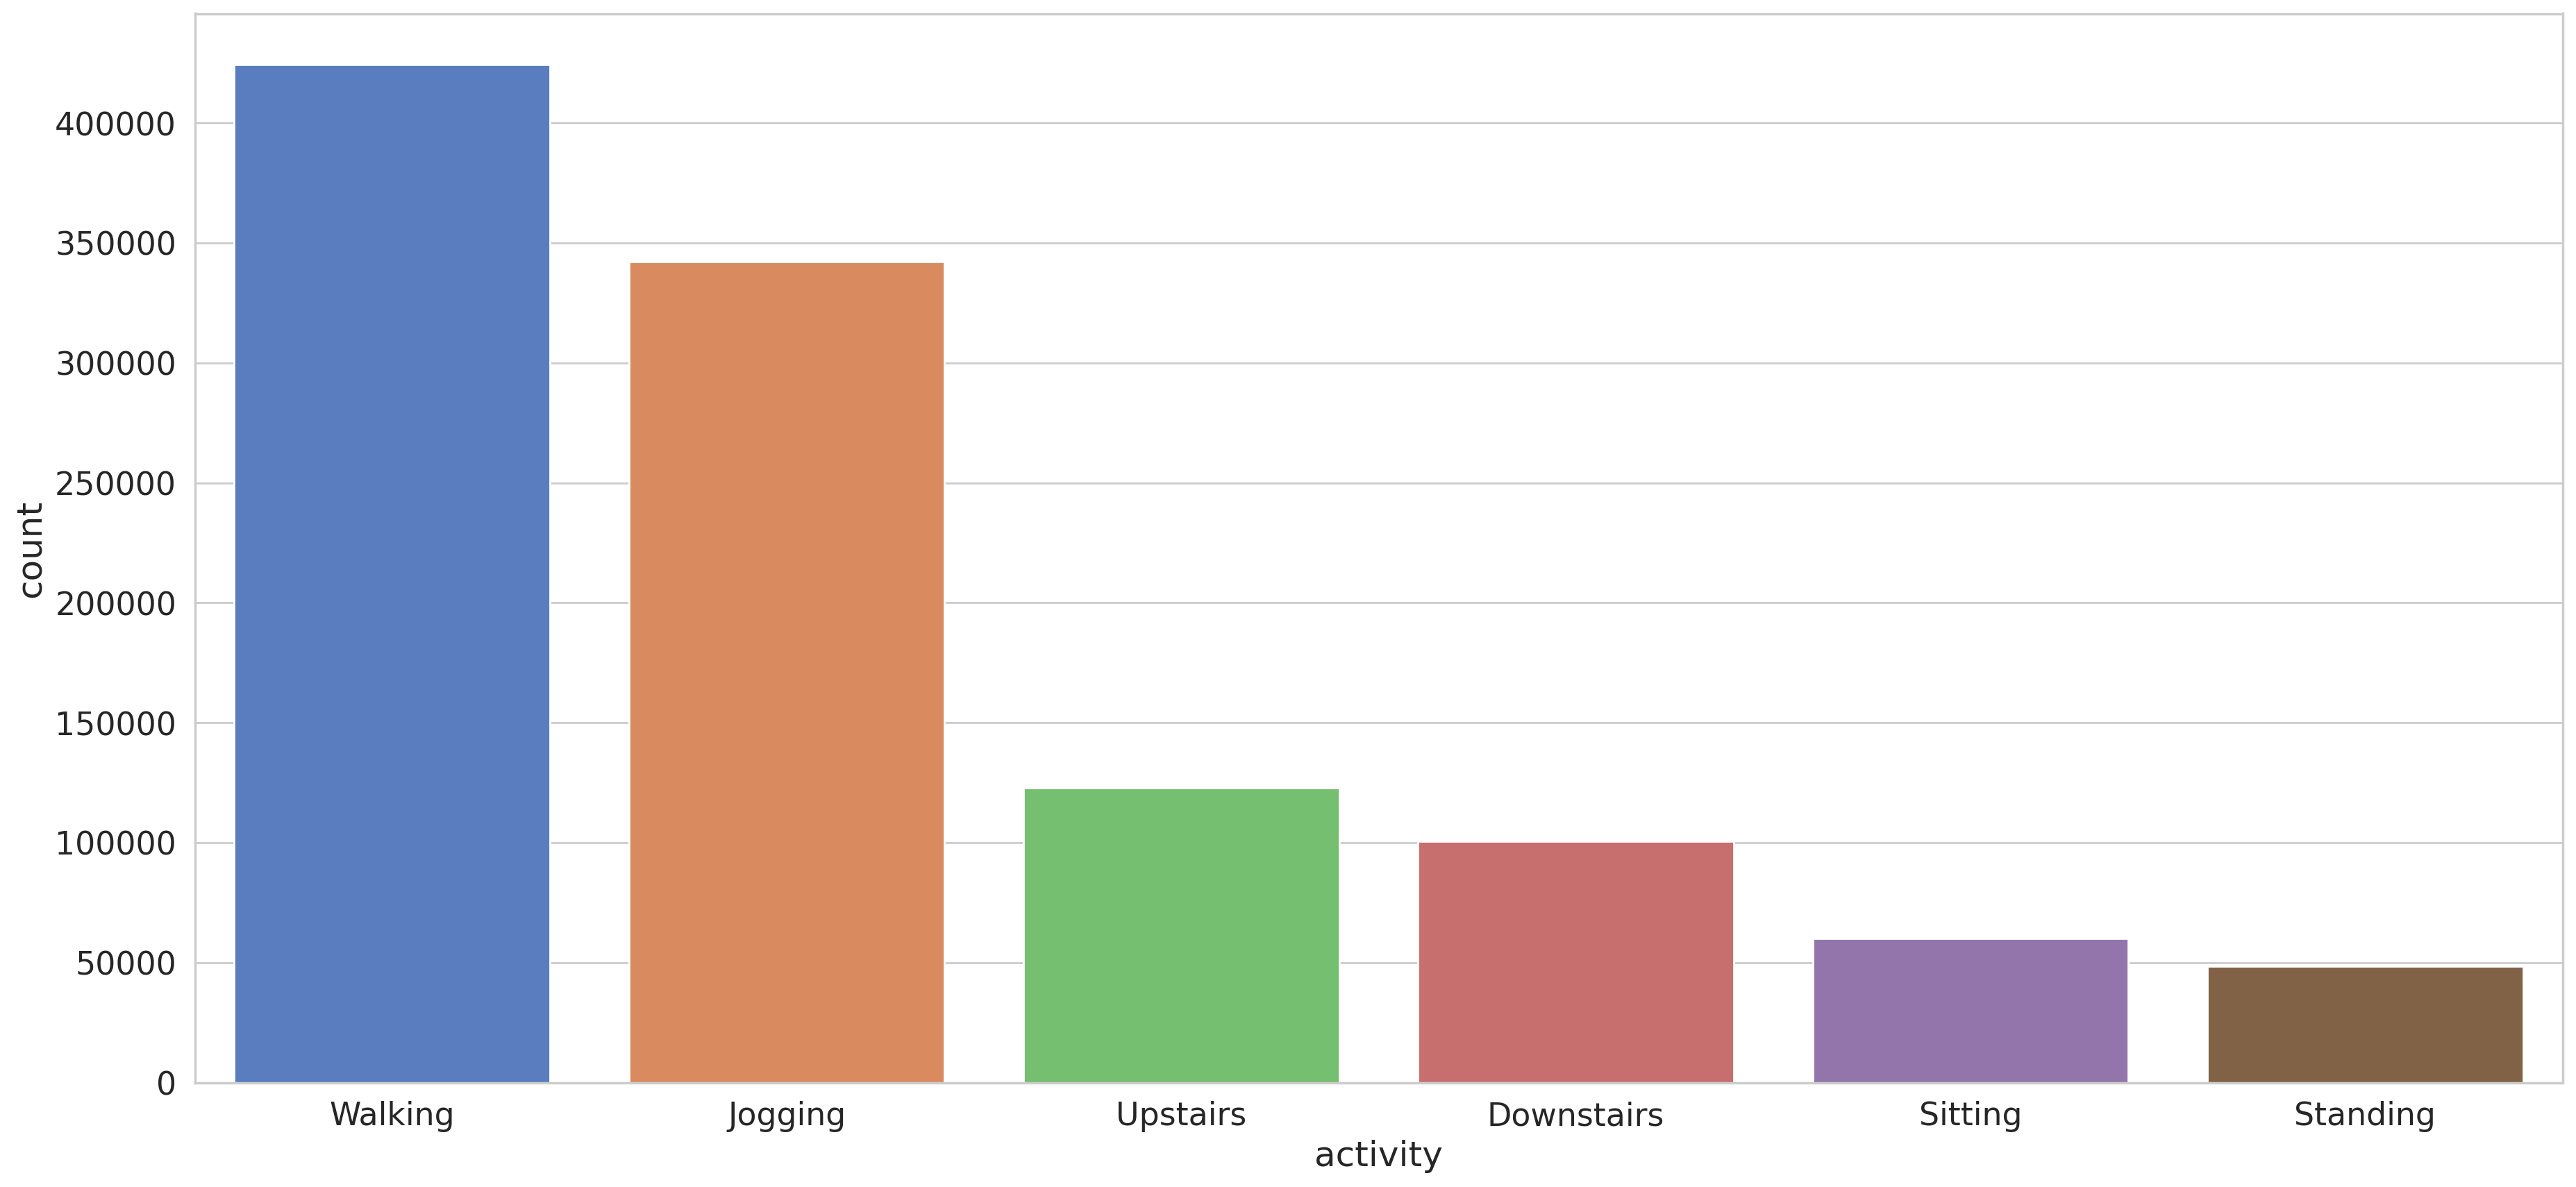

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

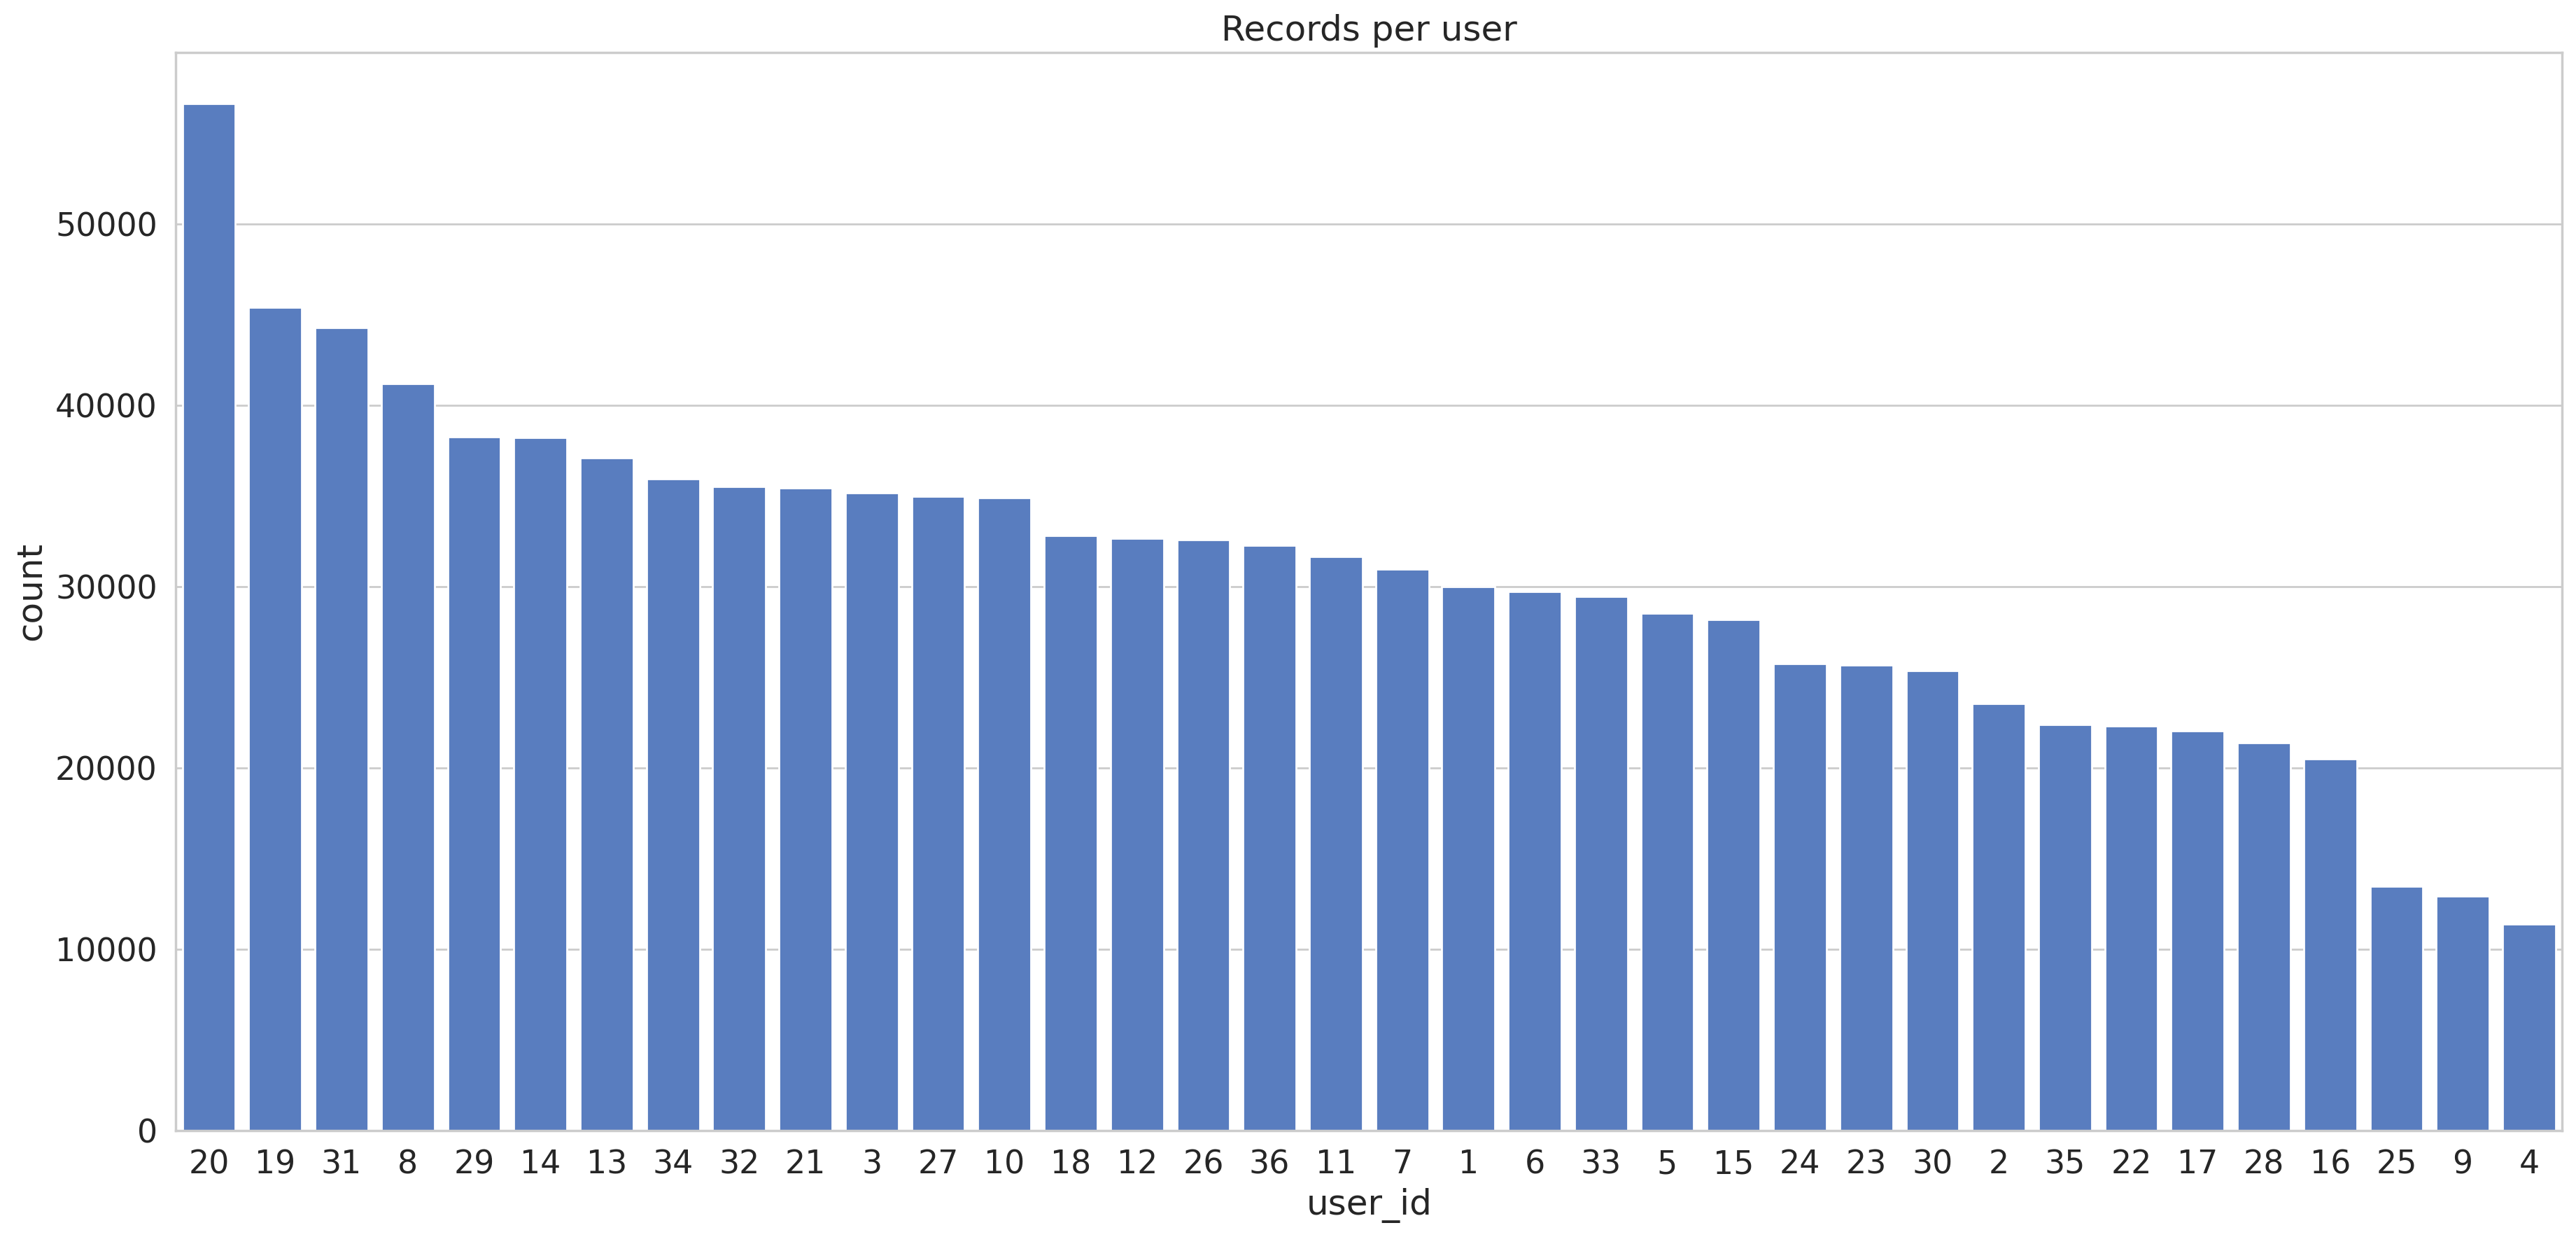

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


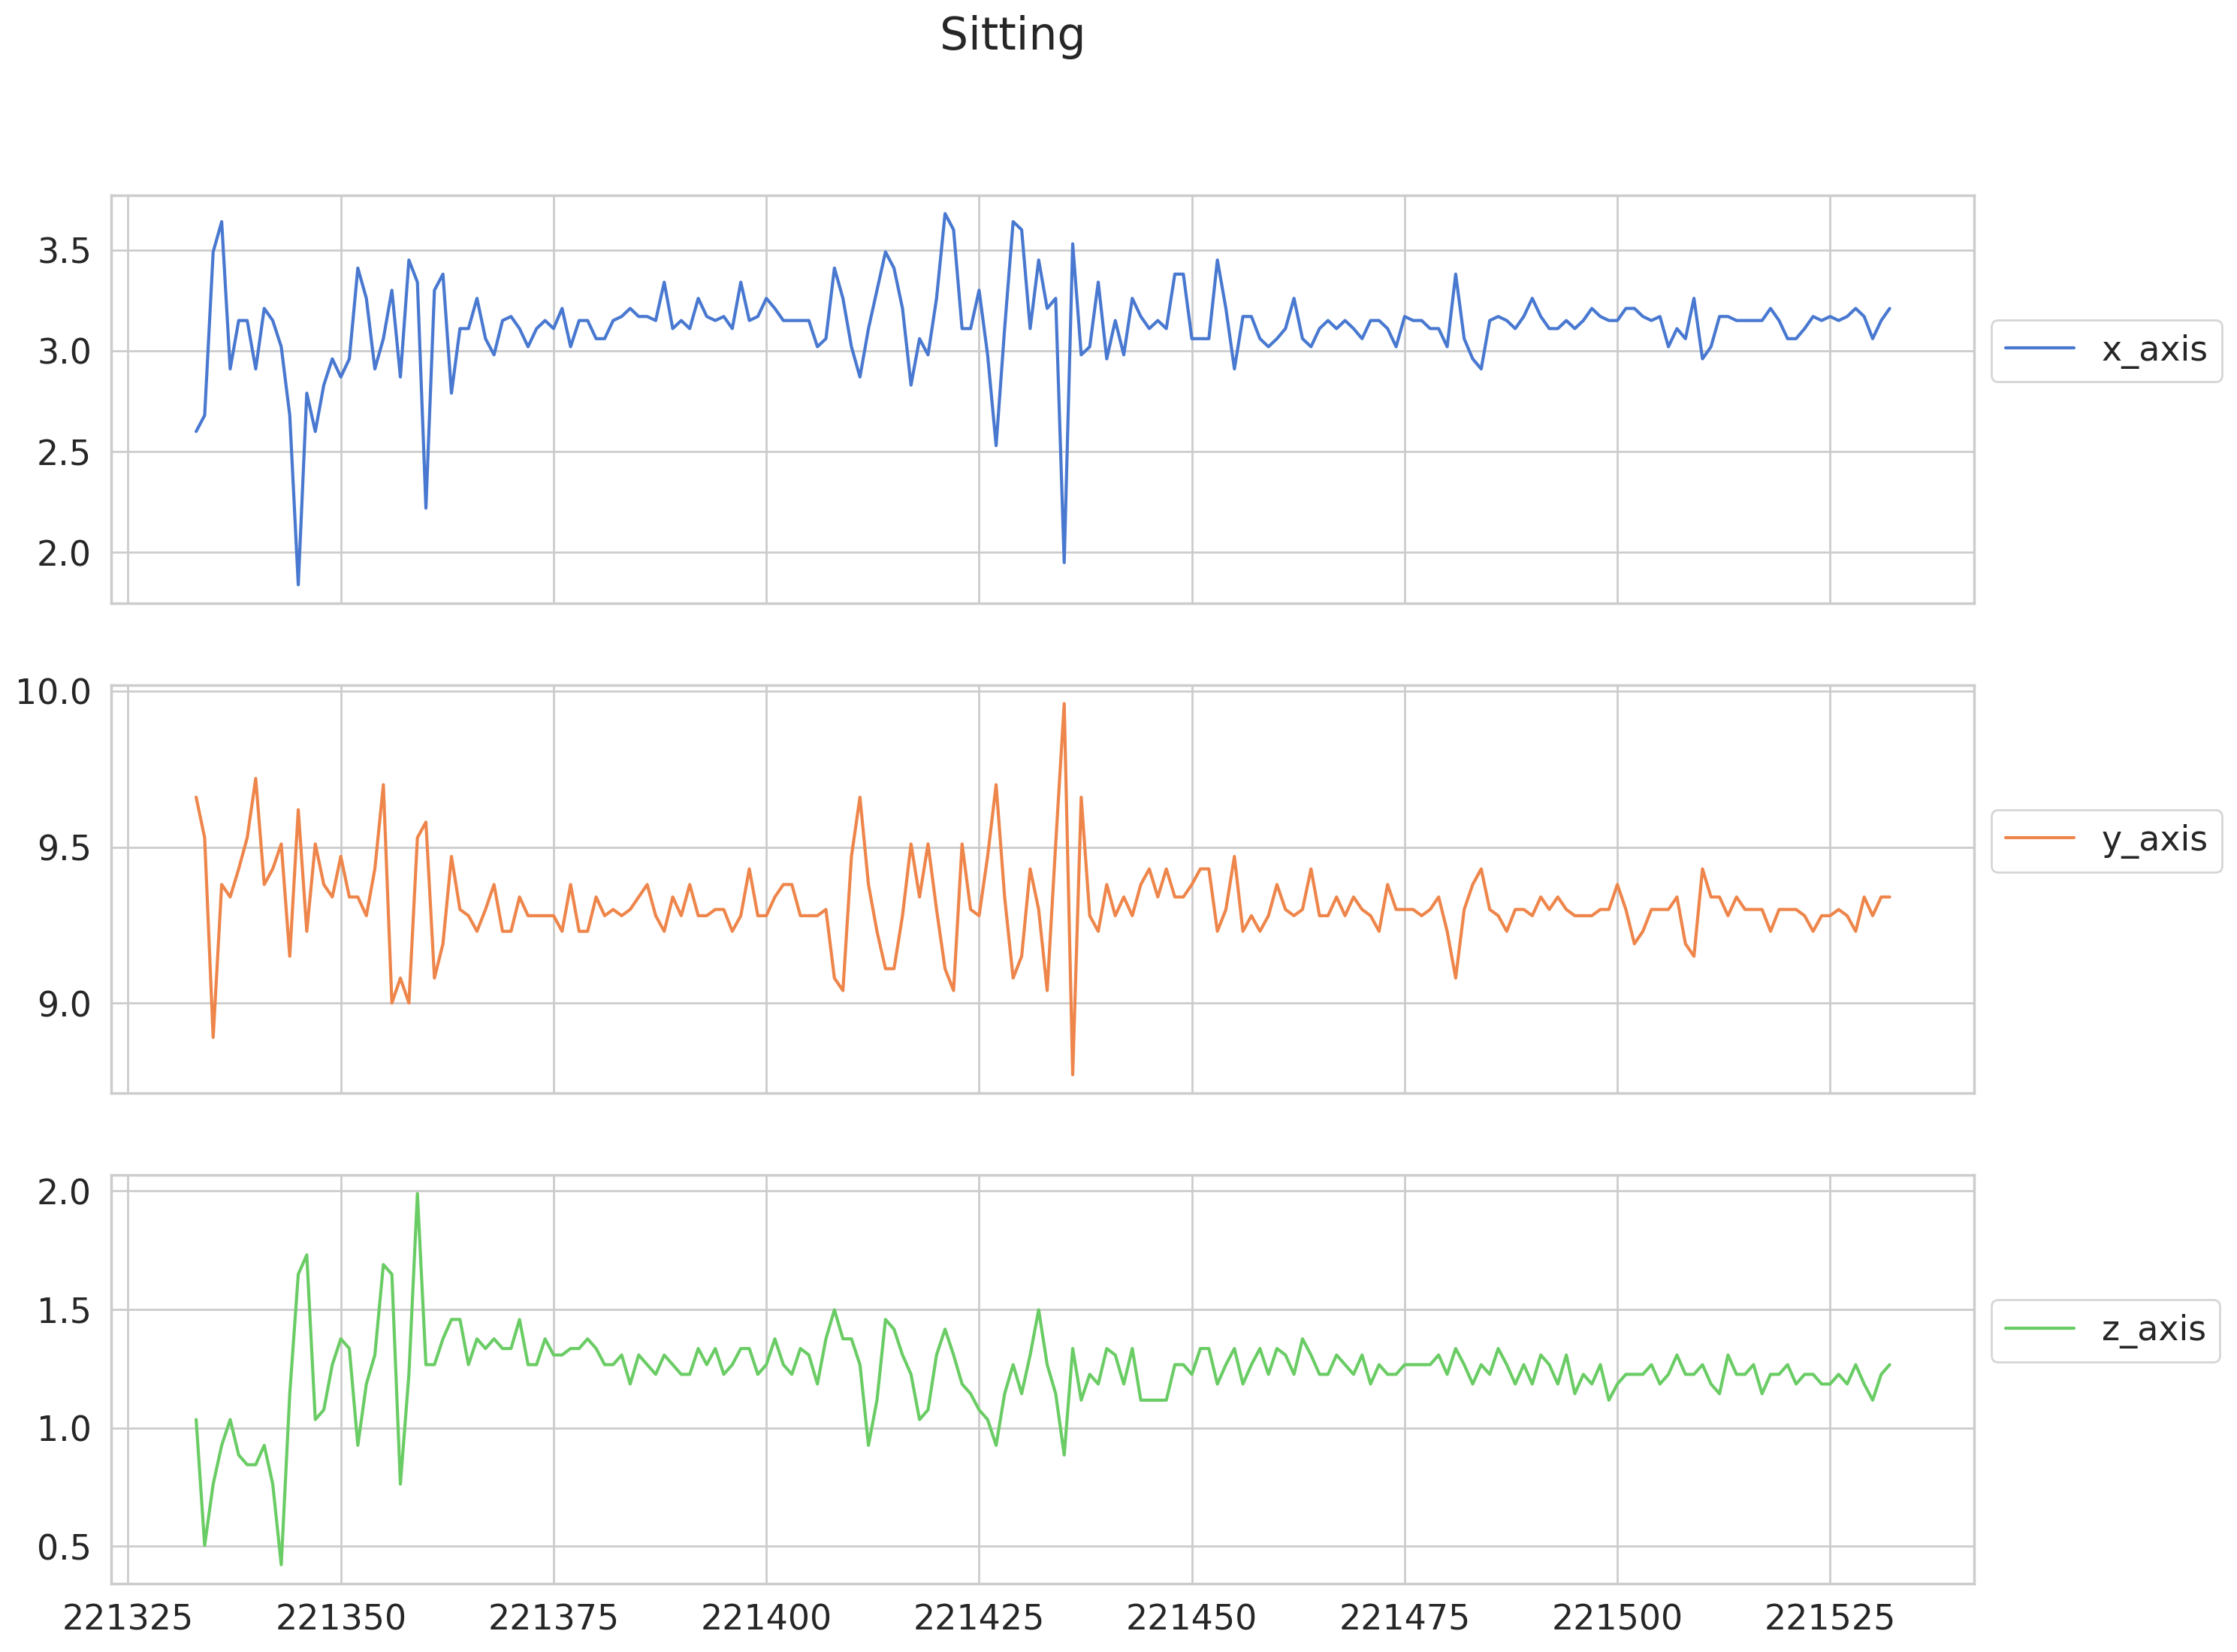

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)


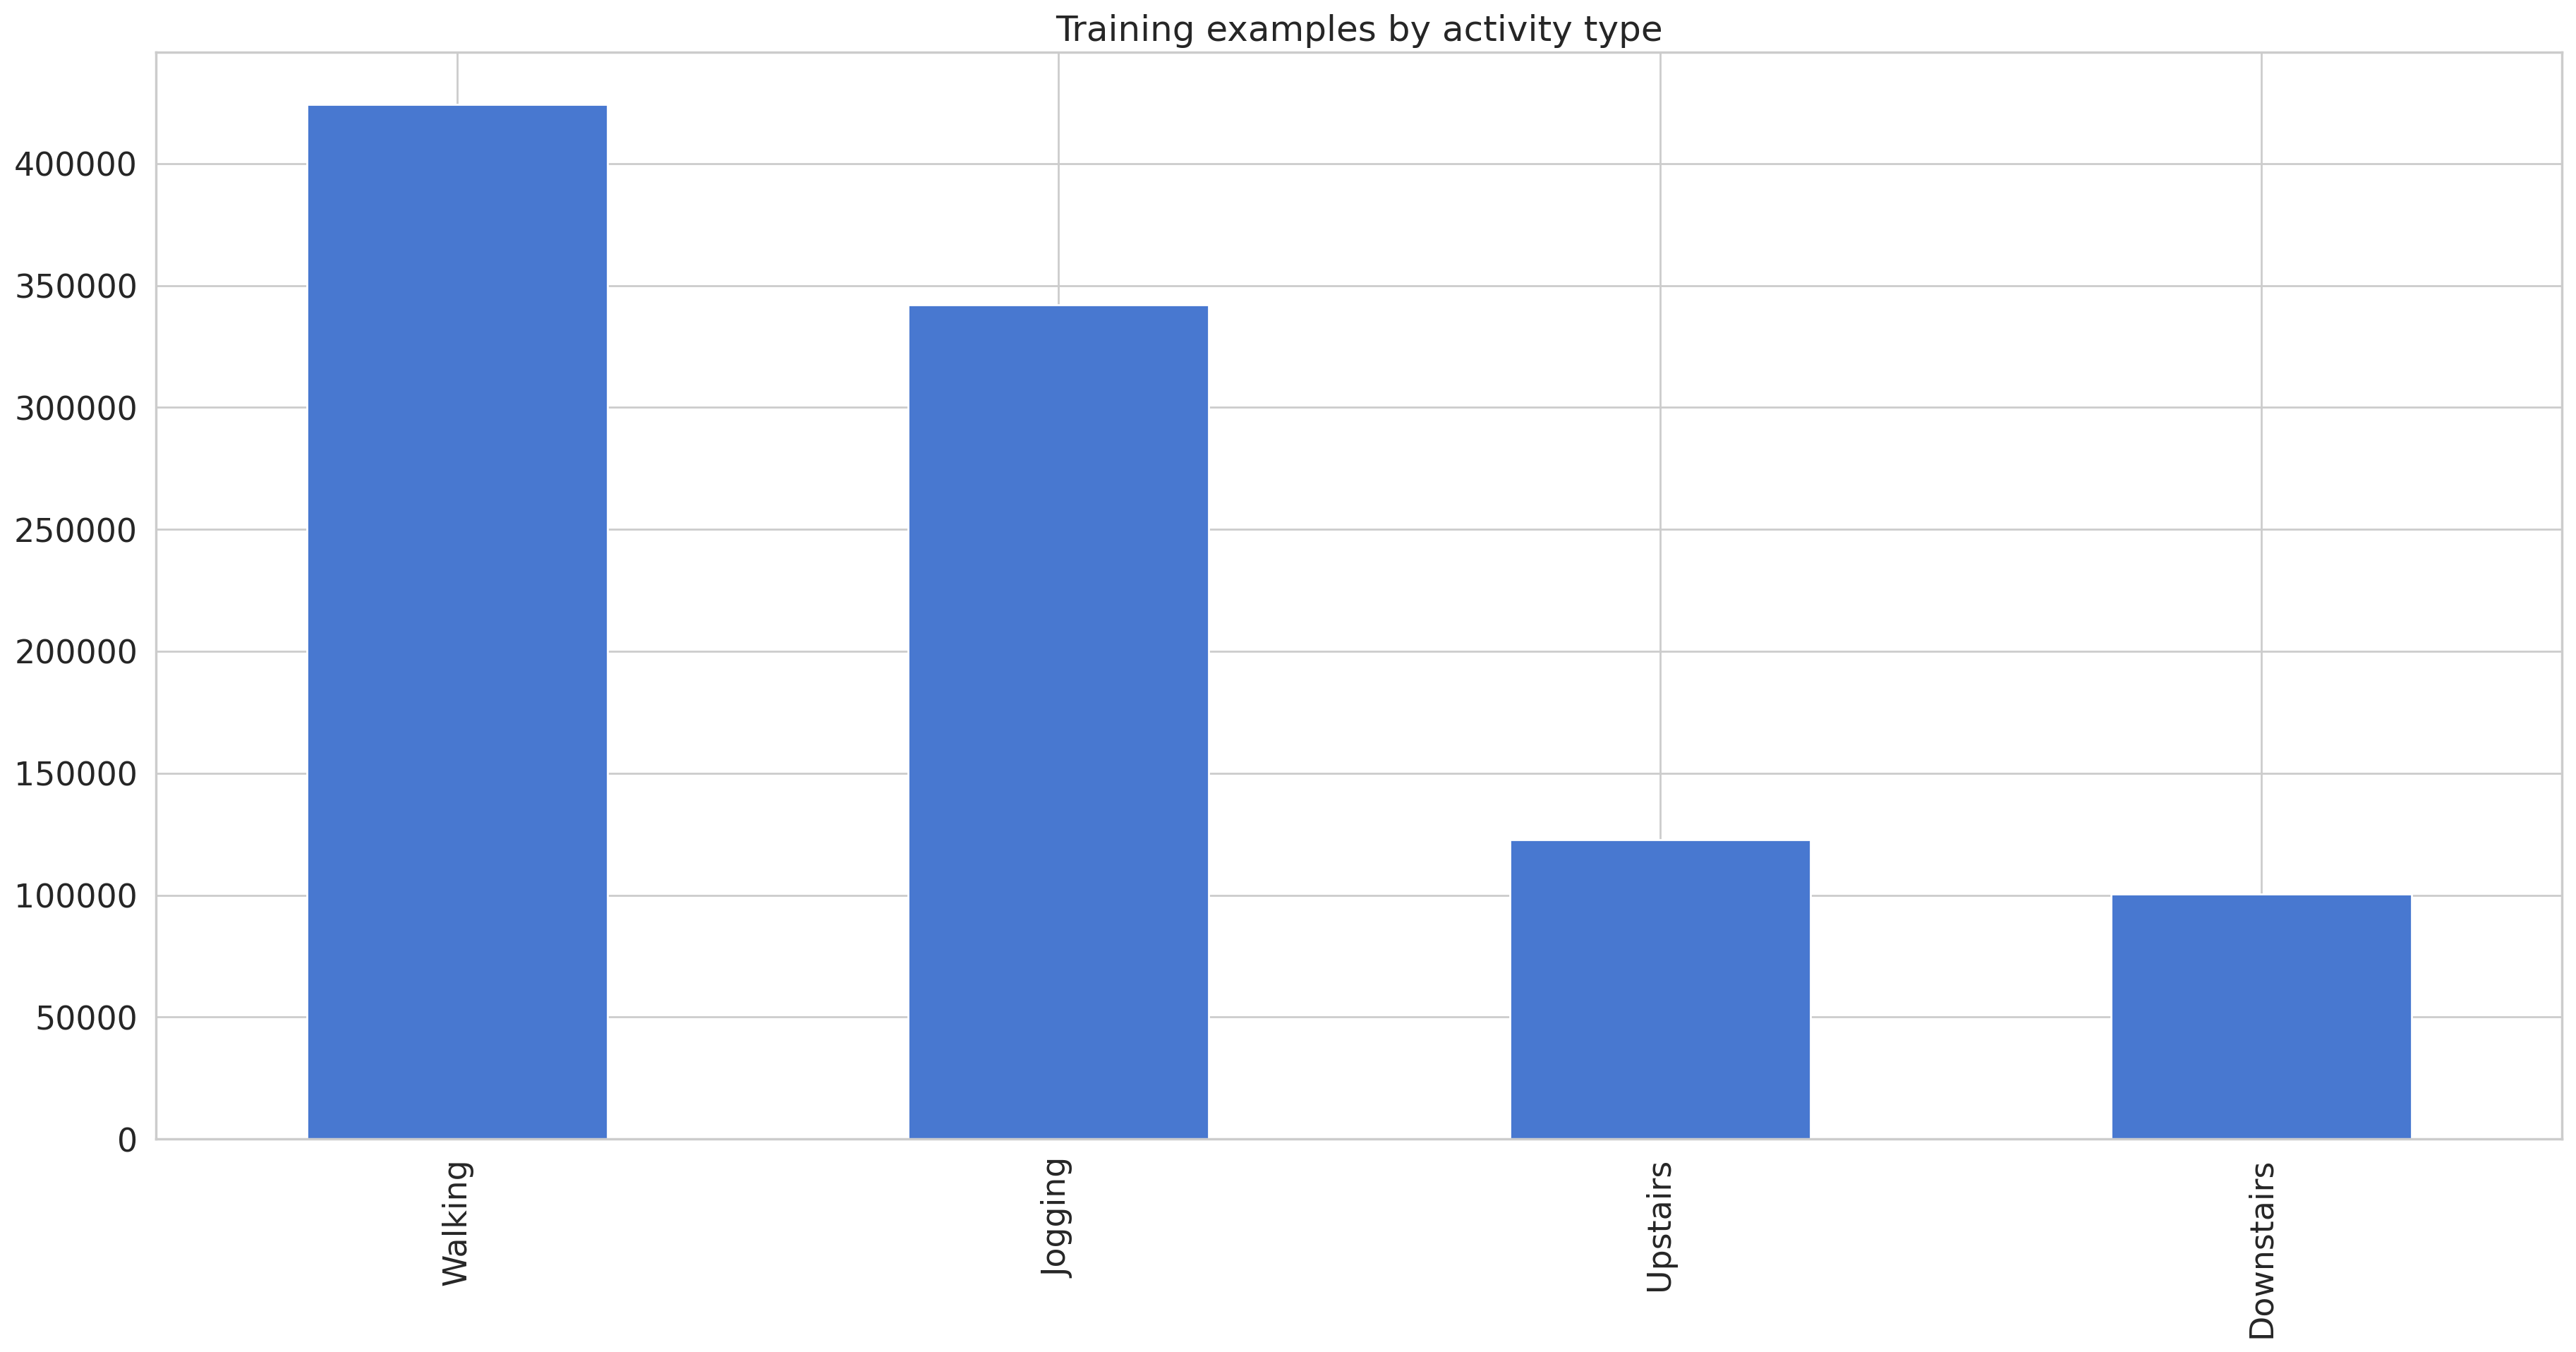

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.139064,0.528798,0.162904,1
1,33,Jogging,49106062271000,0.627996,0.365980,0.257510,1
2,33,Jogging,49106112167000,0.613350,0.322145,0.039629,1
3,33,Jogging,49106222305000,-0.128080,1.197291,0.693271,1
4,33,Jogging,49106332290000,-0.204969,0.463045,1.573395,1
...,...,...,...,...,...,...,...
1093534,19,Downstairs,131357151521000,-0.602151,-0.017241,0.635659,3
1093535,19,Downstairs,131357191438000,-0.987903,0.155172,0.248370,3
1093536,19,Downstairs,131357231630000,-1.235215,0.718391,0.119975,3
1093537,19,Downstairs,131357271516000,-1.065860,0.026437,-0.524103,3


In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63348, 50, 3) (63348, 1)
(19797, 50, 3) (19797, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(63348, 50, 3) (63348, 4) (19797, 50, 3) (19797, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 4)

# LSTM1 - CNN1


In [15]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           67584     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            24640     
                                                                 
 dropout_1 (Dropout)         (None, 48, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                        

In [16]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
62/62 [==============================] - 85s 1s/step - loss: 0.8387 - accuracy: 0.6919 - val_loss: 0.6678 - val_accuracy: 0.7633
Epoch 2/10
62/62 [==============================] - 81s 1s/step - loss: 0.5620 - accuracy: 0.7853 - val_loss: 0.4883 - val_accuracy: 0.8217
Epoch 3/10
62/62 [==============================] - 82s 1s/step - loss: 0.4393 - accuracy: 0.8342 - val_loss: 0.4125 - val_accuracy: 0.8591
Epoch 4/10
62/62 [==============================] - 89s 1s/step - loss: 0.3558 - accuracy: 0.8695 - val_loss: 0.3323 - val_accuracy: 0.8916
Epoch 5/10
62/62 [==============================] - 83s 1s/step - loss: 0.2922 - accuracy: 0.8954 - val_loss: 0.2672 - val_accuracy: 0.9086
Epoch 6/10
62/62 [==============================] - 83s 1s/step - loss: 0.2441 - accuracy: 0.9139 - val_loss: 0.2324 - val_accuracy: 0.9220
Epoch 7/10
62/62 [==============================] - 76s 1s/step - loss: 0.2111 - accuracy: 0.9260 - val_loss: 0.2080 - val_accuracy: 0.9343
Epoch 8/10
62/62 [==

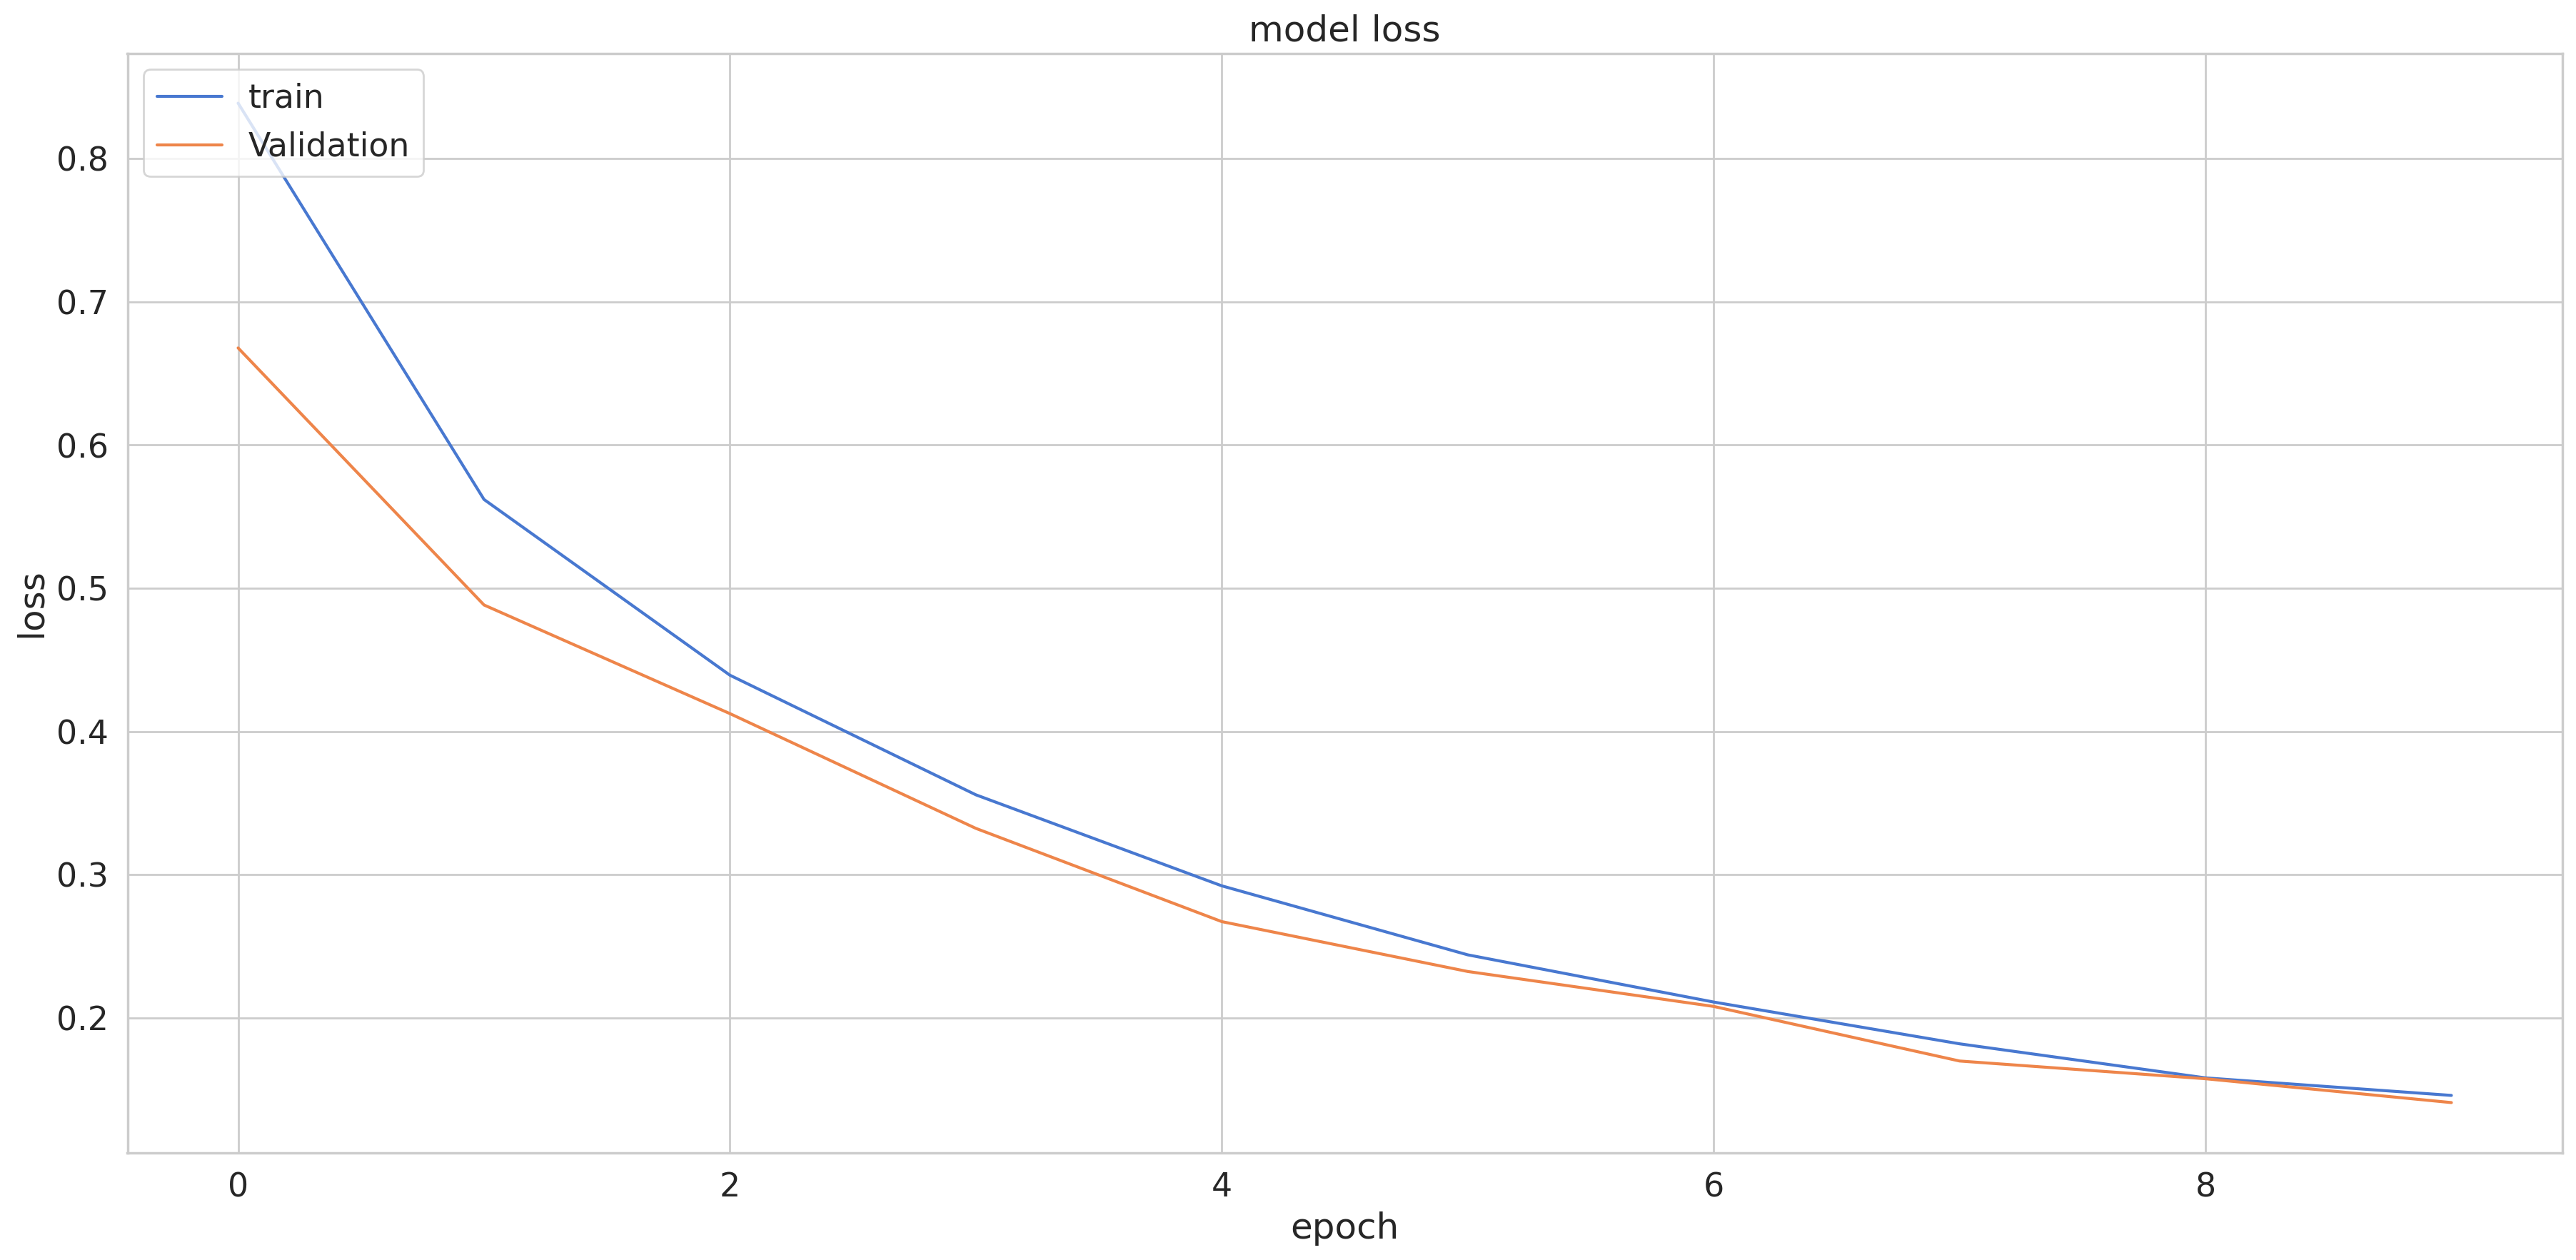

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

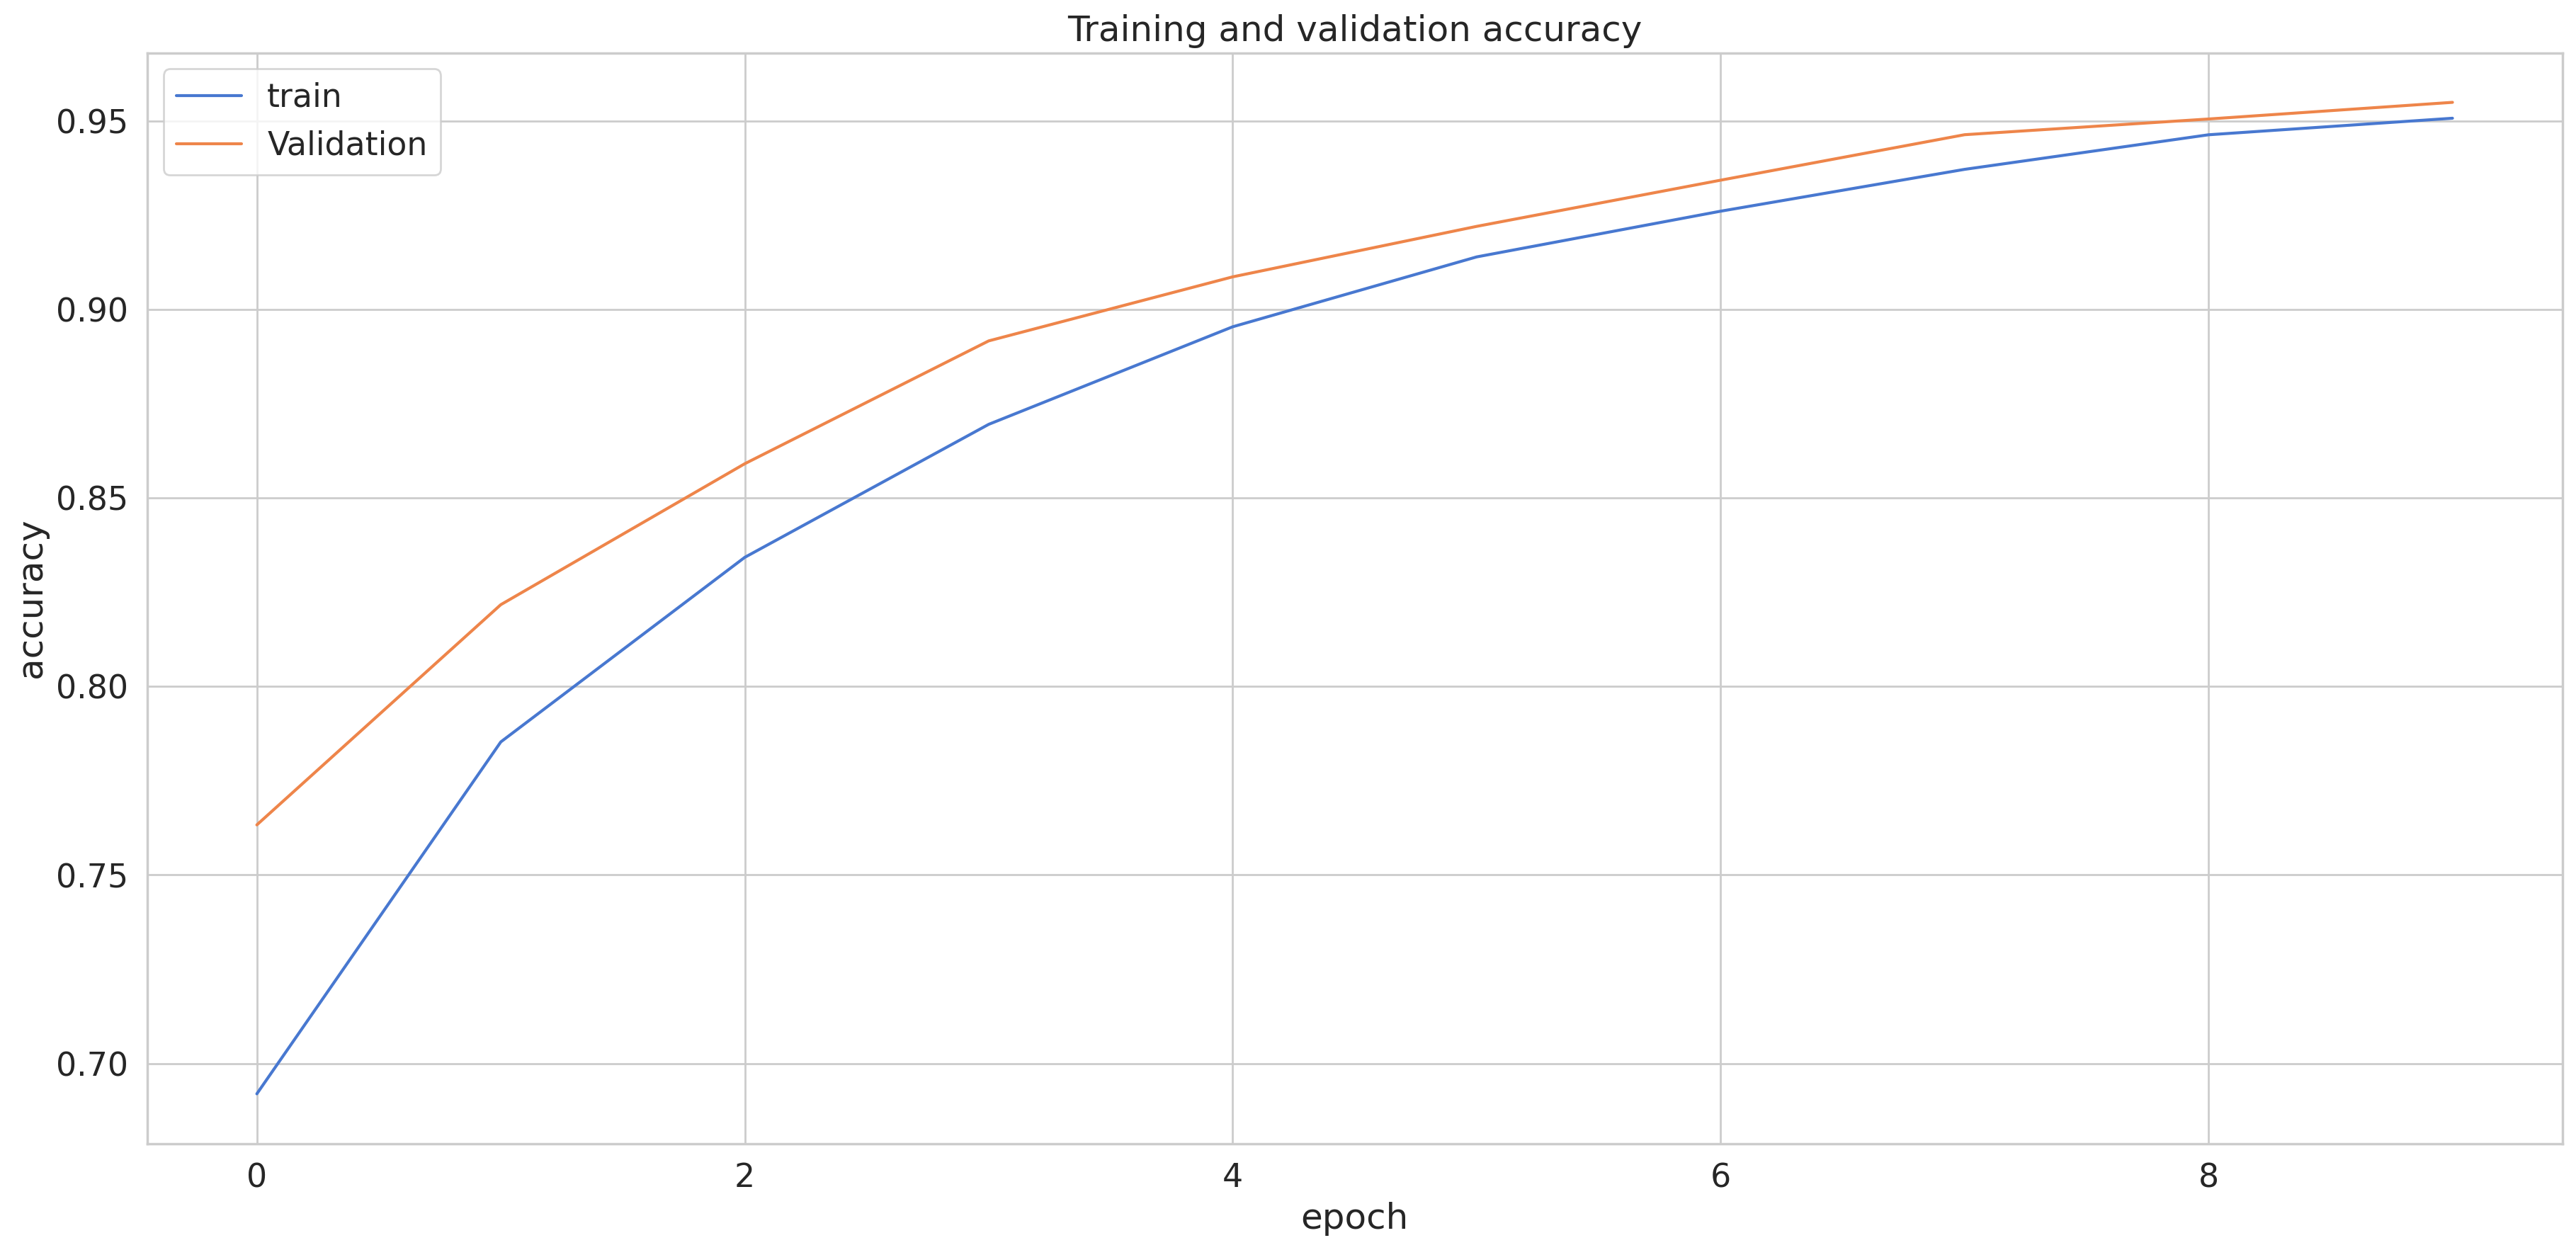

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 19s 30ms/step
f1_score =  0.9547450955026143
0.9551447188968025
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8490
           1       0.97      0.99      0.98      6843
           2       0.87      0.85      0.86      2459
           3       0.88      0.85      0.86      2005

    accuracy                           0.96     19797
   macro avg       0.93      0.92      0.92     19797
weighted avg       0.95      0.96      0.95     19797



<Axes: >

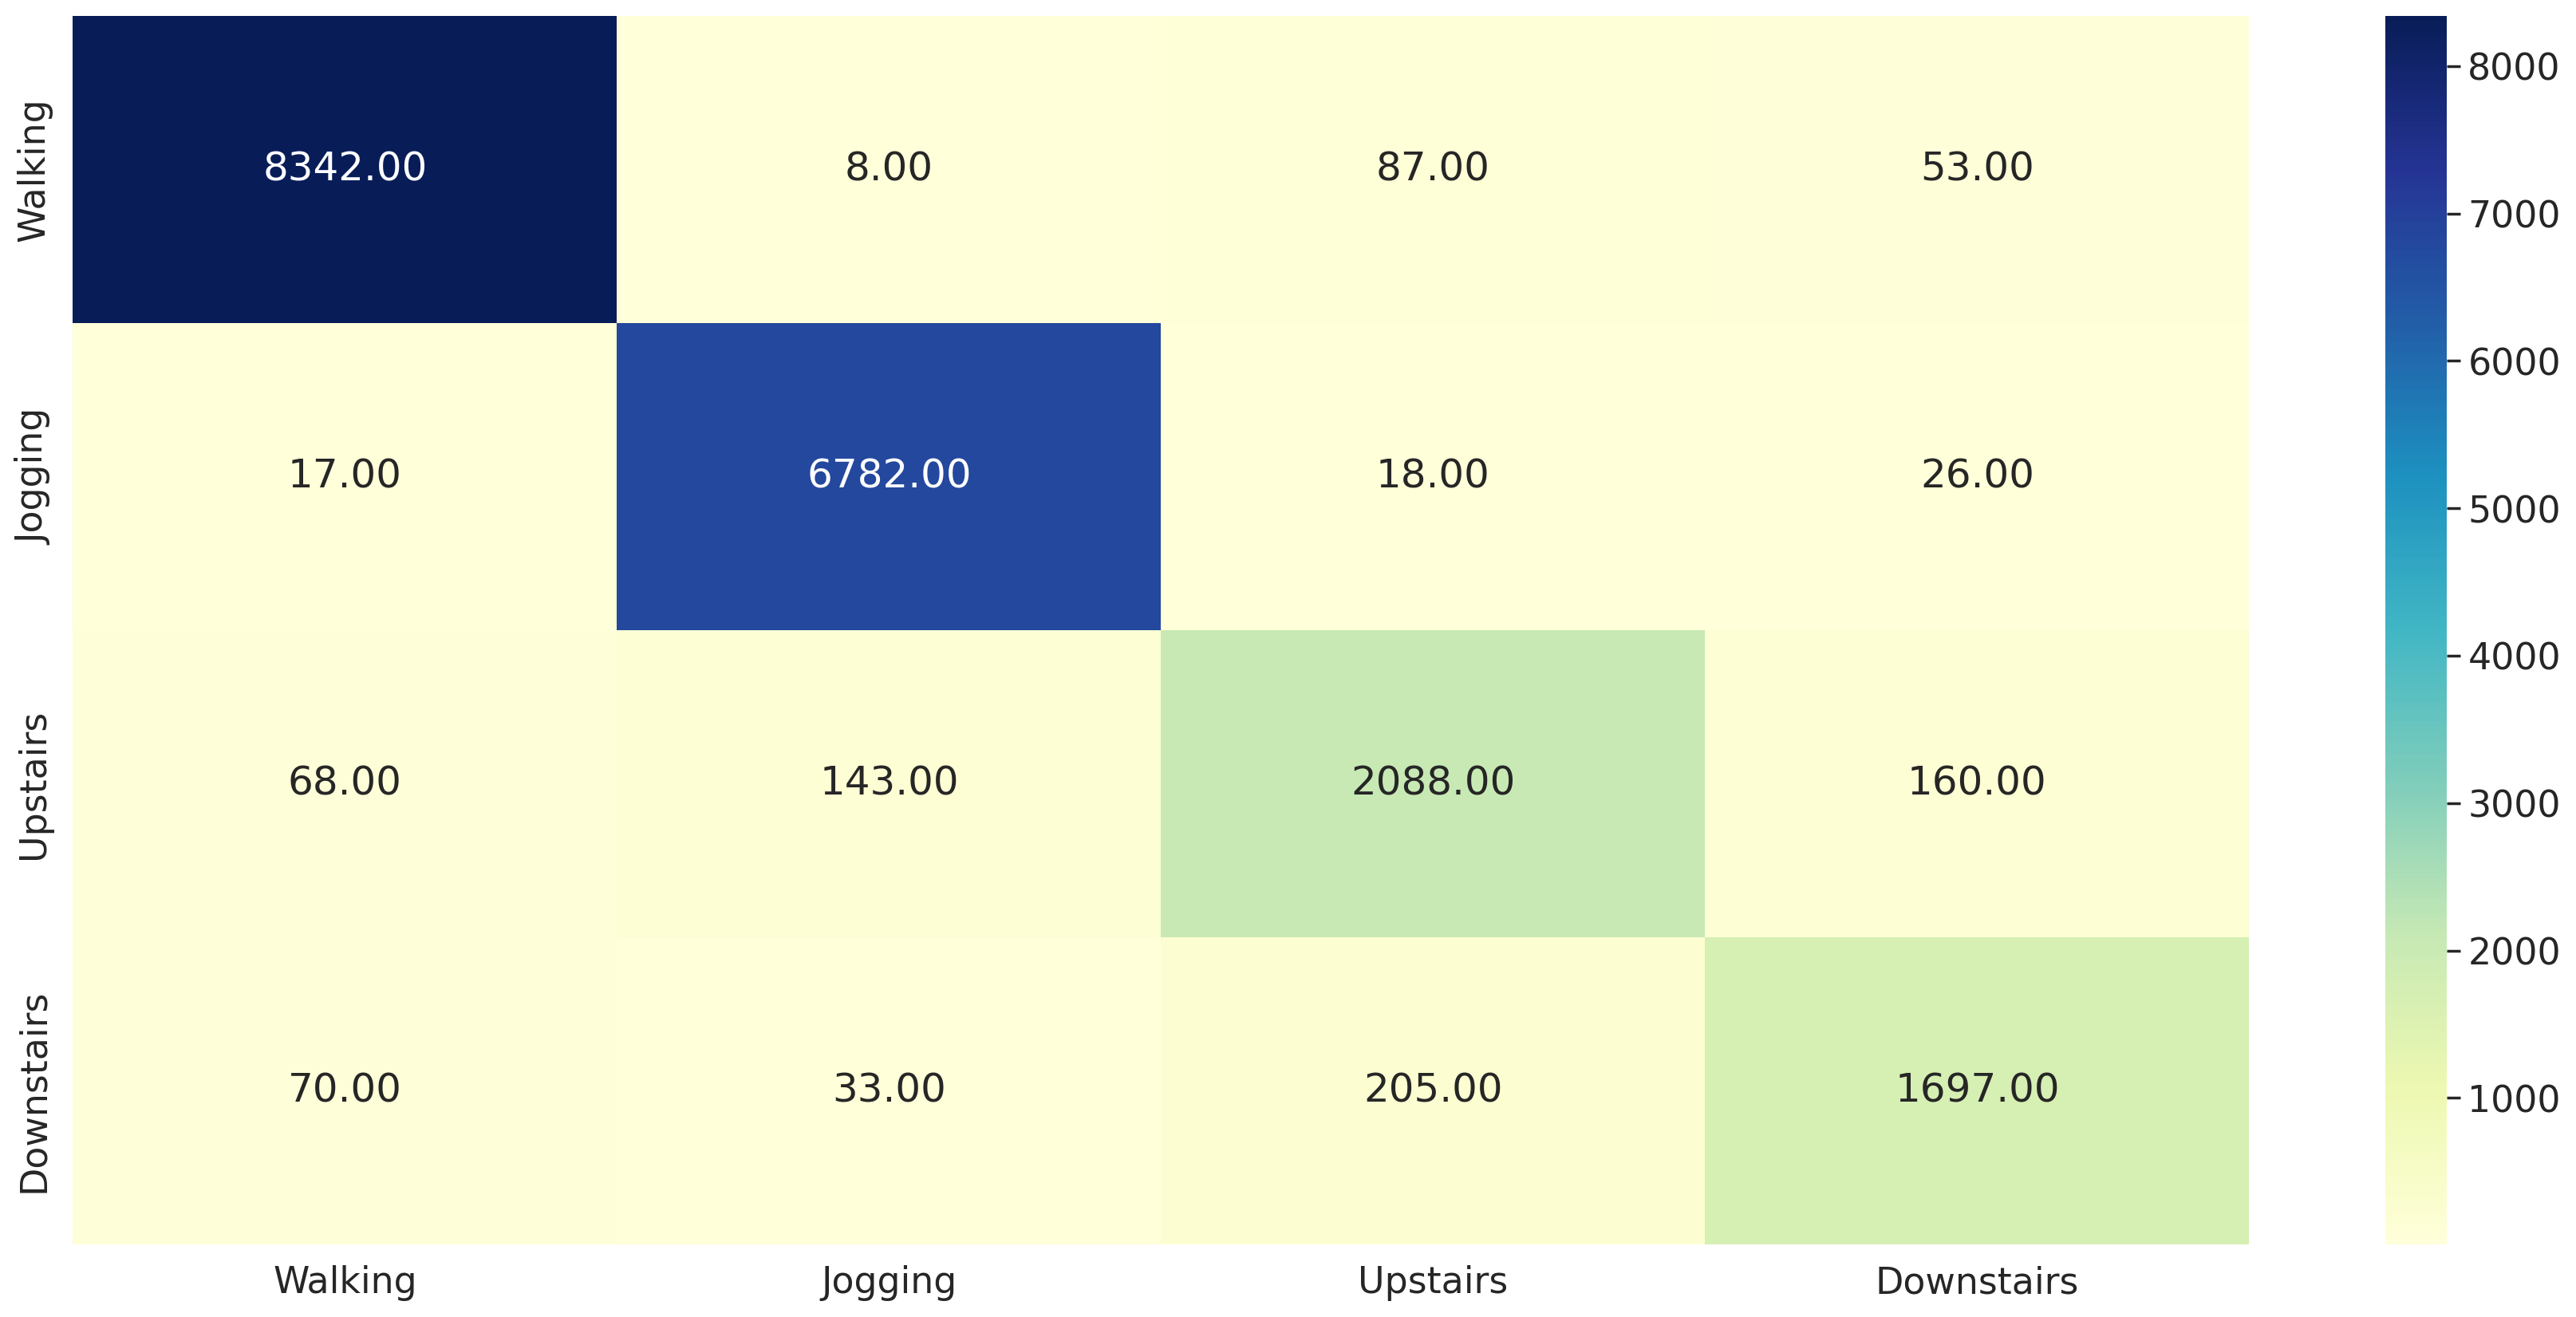

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM1 - CNN2

In [20]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 64)            24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 dropout_3 (Dropout)         (None, 46, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                      

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 113s 223ms/step - loss: 0.4463 - accuracy: 0.8370 - val_loss: 0.2257 - val_accuracy: 0.9338
Epoch 2/10
495/495 [==============================] - 104s 210ms/step - loss: 0.1822 - accuracy: 0.9378 - val_loss: 0.1272 - val_accuracy: 0.9607
Epoch 3/10
495/495 [==============================] - 103s 209ms/step - loss: 0.1256 - accuracy: 0.9580 - val_loss: 0.1014 - val_accuracy: 0.9694
Epoch 4/10
495/495 [==============================] - 101s 203ms/step - loss: 0.0983 - accuracy: 0.9668 - val_loss: 0.0808 - val_accuracy: 0.9732
Epoch 5/10
495/495 [==============================] - 104s 210ms/step - loss: 0.0811 - accuracy: 0.9717 - val_loss: 0.0718 - val_accuracy: 0.9766
Epoch 6/10
495/495 [==============================] - 104s 211ms/step - loss: 0.0665 - accuracy: 0.9776 - val_loss: 0.0591 - val_accuracy: 0.9799
Epoch 7/10
495/495 [==============================] - 104s 210ms/step - loss: 0.0612 - accuracy: 0.9795 - val_loss: 0.0669 -

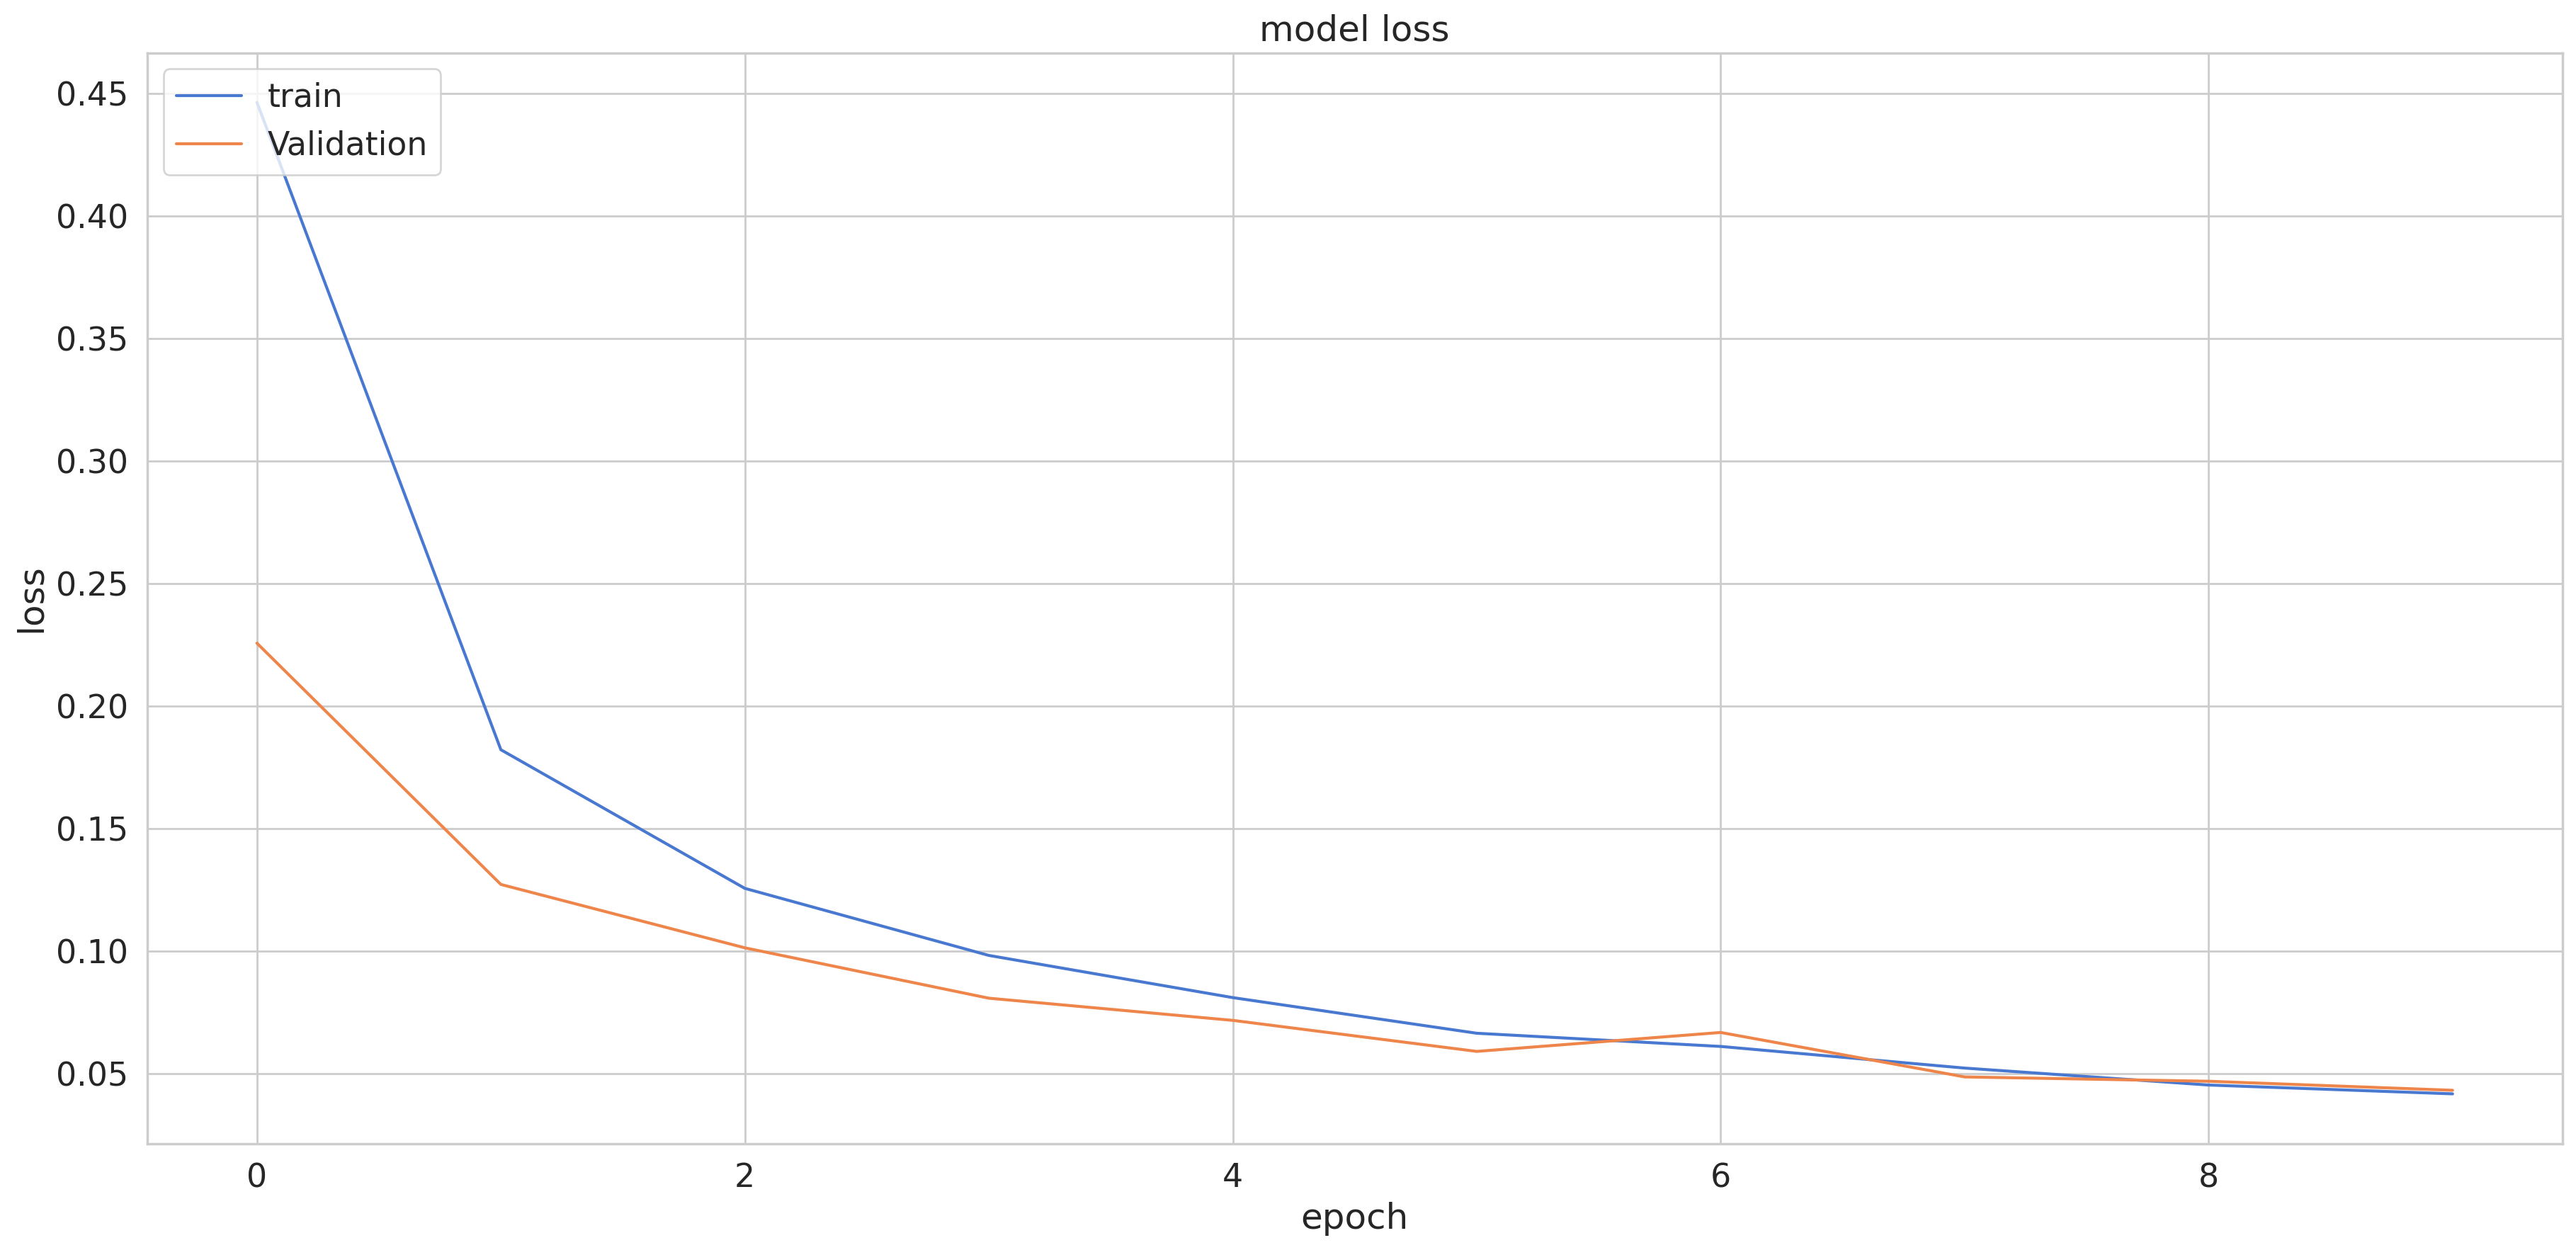

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

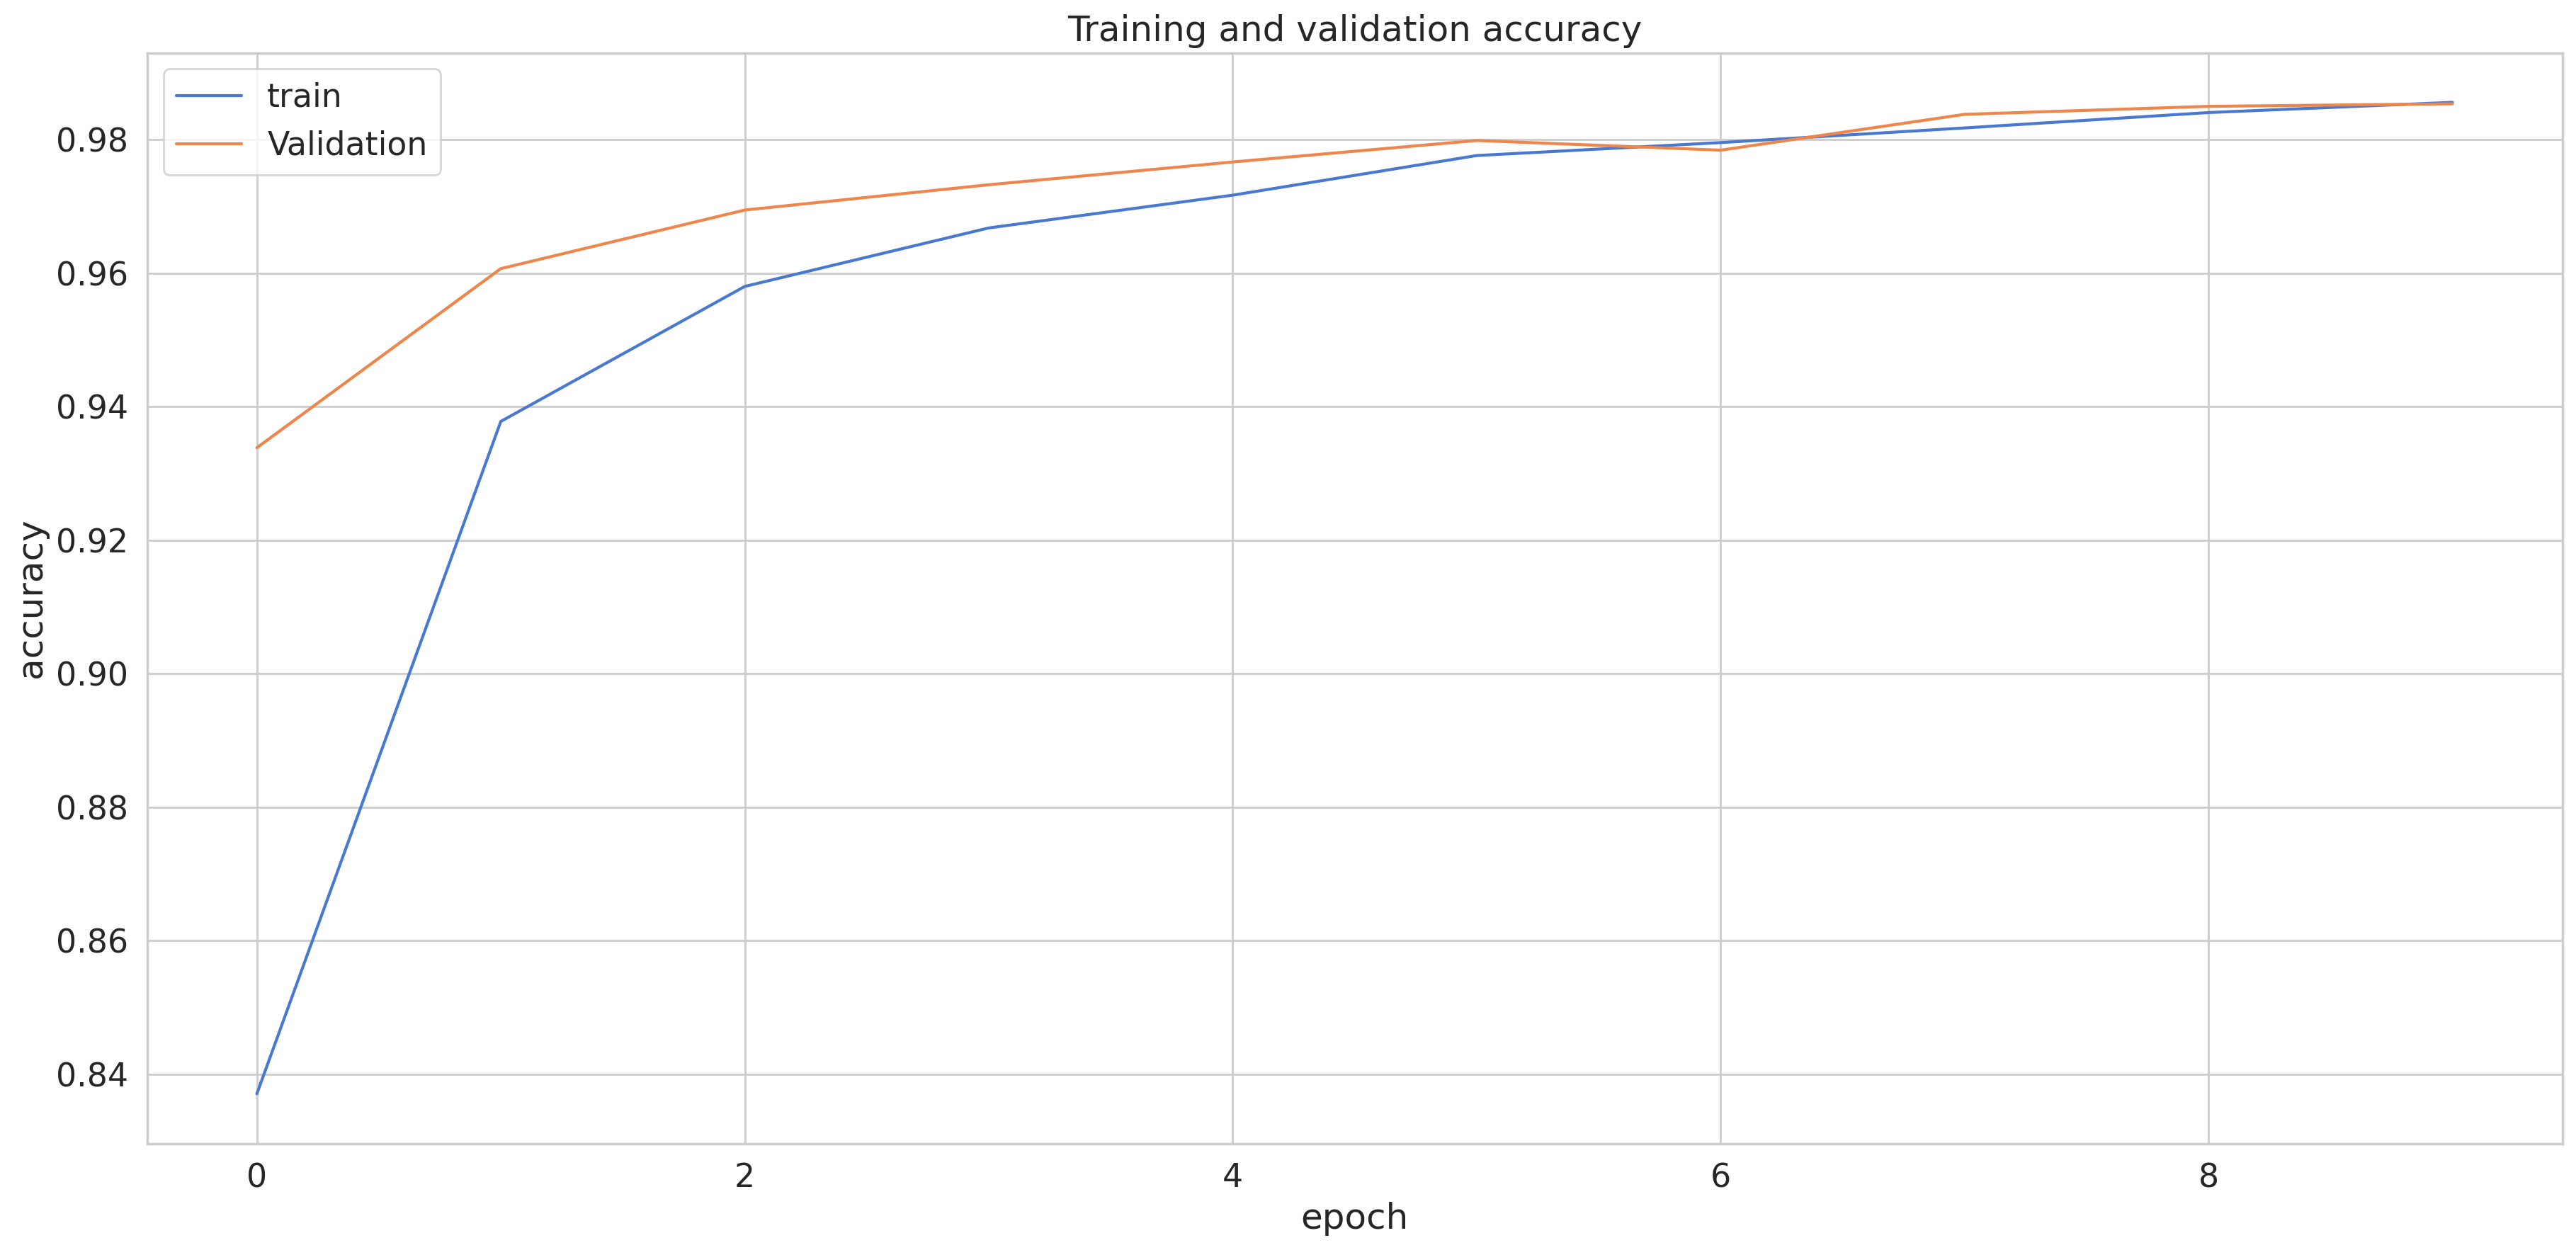

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 19s 30ms/step
f1_score =  0.9865649746060542
0.9865131080466737
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.97      0.95      0.96      2459
           3       0.94      0.97      0.95      2005

    accuracy                           0.99     19797
   macro avg       0.97      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

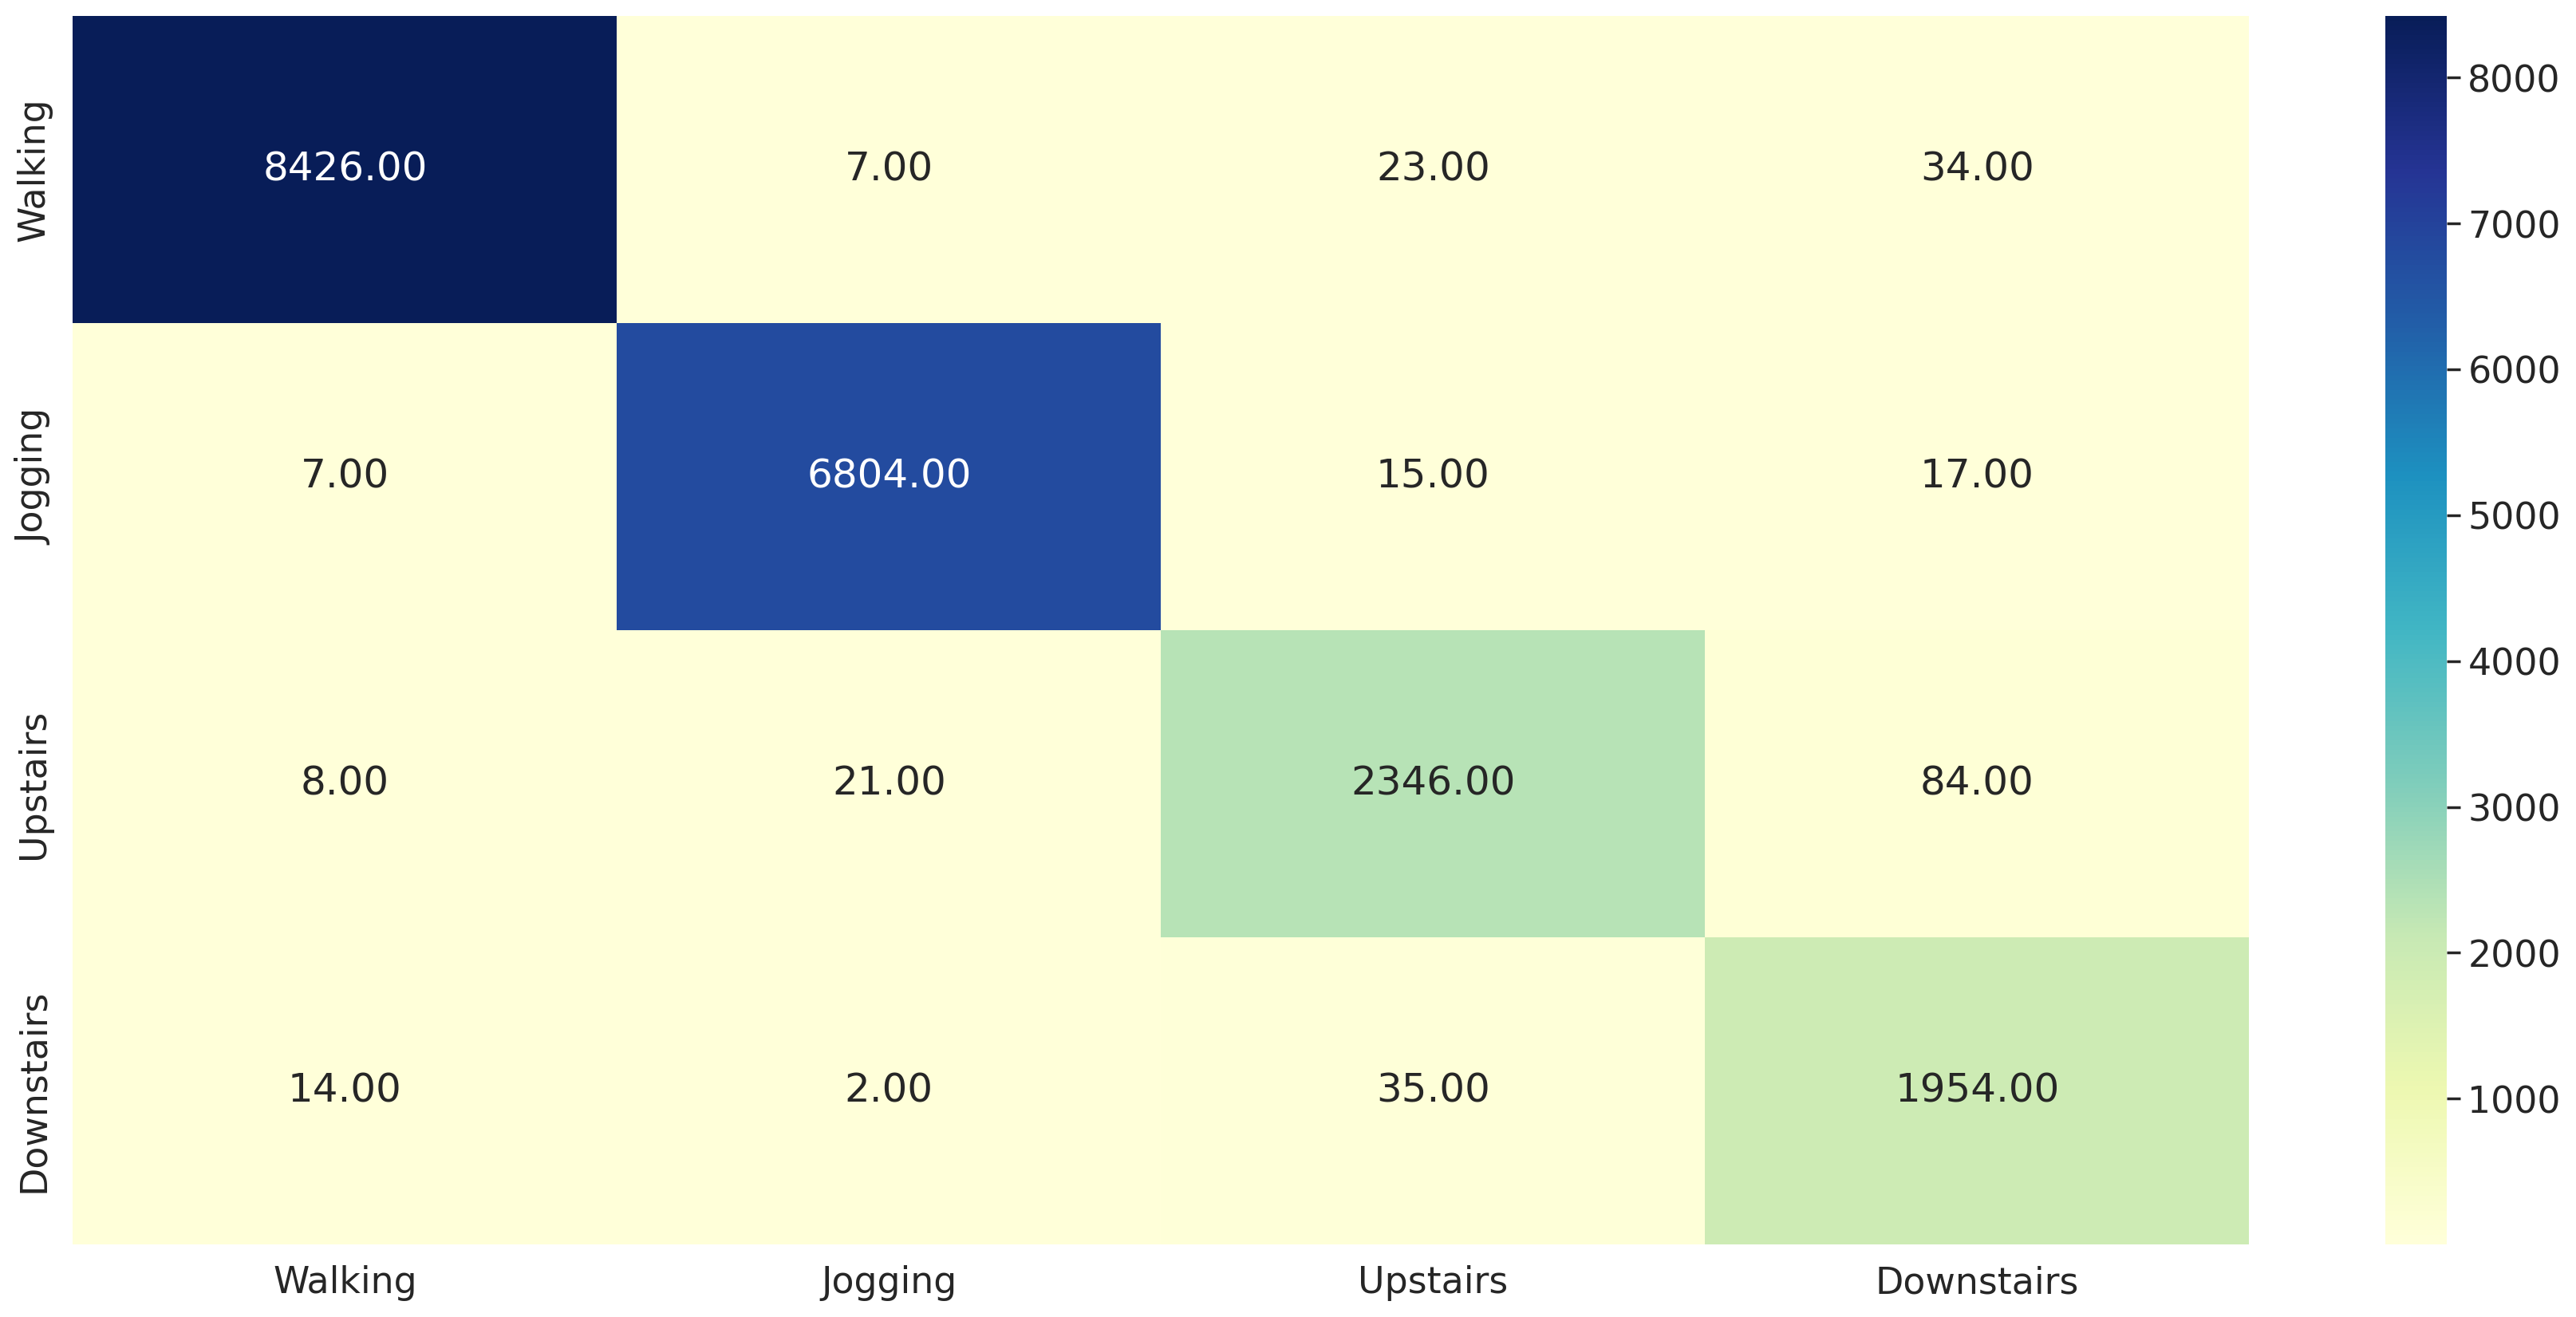

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2 - CNN1

In [25]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 64)            24640     
                                                                 
 dropout_6 (Dropout)         (None, 48, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 64)           

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 214s 422ms/step - loss: 0.5349 - accuracy: 0.8032 - val_loss: 0.3241 - val_accuracy: 0.8910
Epoch 2/10
495/495 [==============================] - 204s 412ms/step - loss: 0.2393 - accuracy: 0.9149 - val_loss: 0.1804 - val_accuracy: 0.9451
Epoch 3/10
495/495 [==============================] - 204s 411ms/step - loss: 0.1527 - accuracy: 0.9482 - val_loss: 0.1221 - val_accuracy: 0.9634
Epoch 4/10
495/495 [==============================] - 209s 422ms/step - loss: 0.1145 - accuracy: 0.9610 - val_loss: 0.1067 - val_accuracy: 0.9677
Epoch 5/10
495/495 [==============================] - 206s 415ms/step - loss: 0.0929 - accuracy: 0.9677 - val_loss: 0.0848 - val_accuracy: 0.9727
Epoch 6/10
495/495 [==============================] - 208s 421ms/step - loss: 0.0774 - accuracy: 0.9743 - val_loss: 0.0848 - val_accuracy: 0.9740
Epoch 7/10
495/495 [==============================] - 204s 413ms/step - loss: 0.0636 - accuracy: 0.9787 - val_loss: 0.0625 -

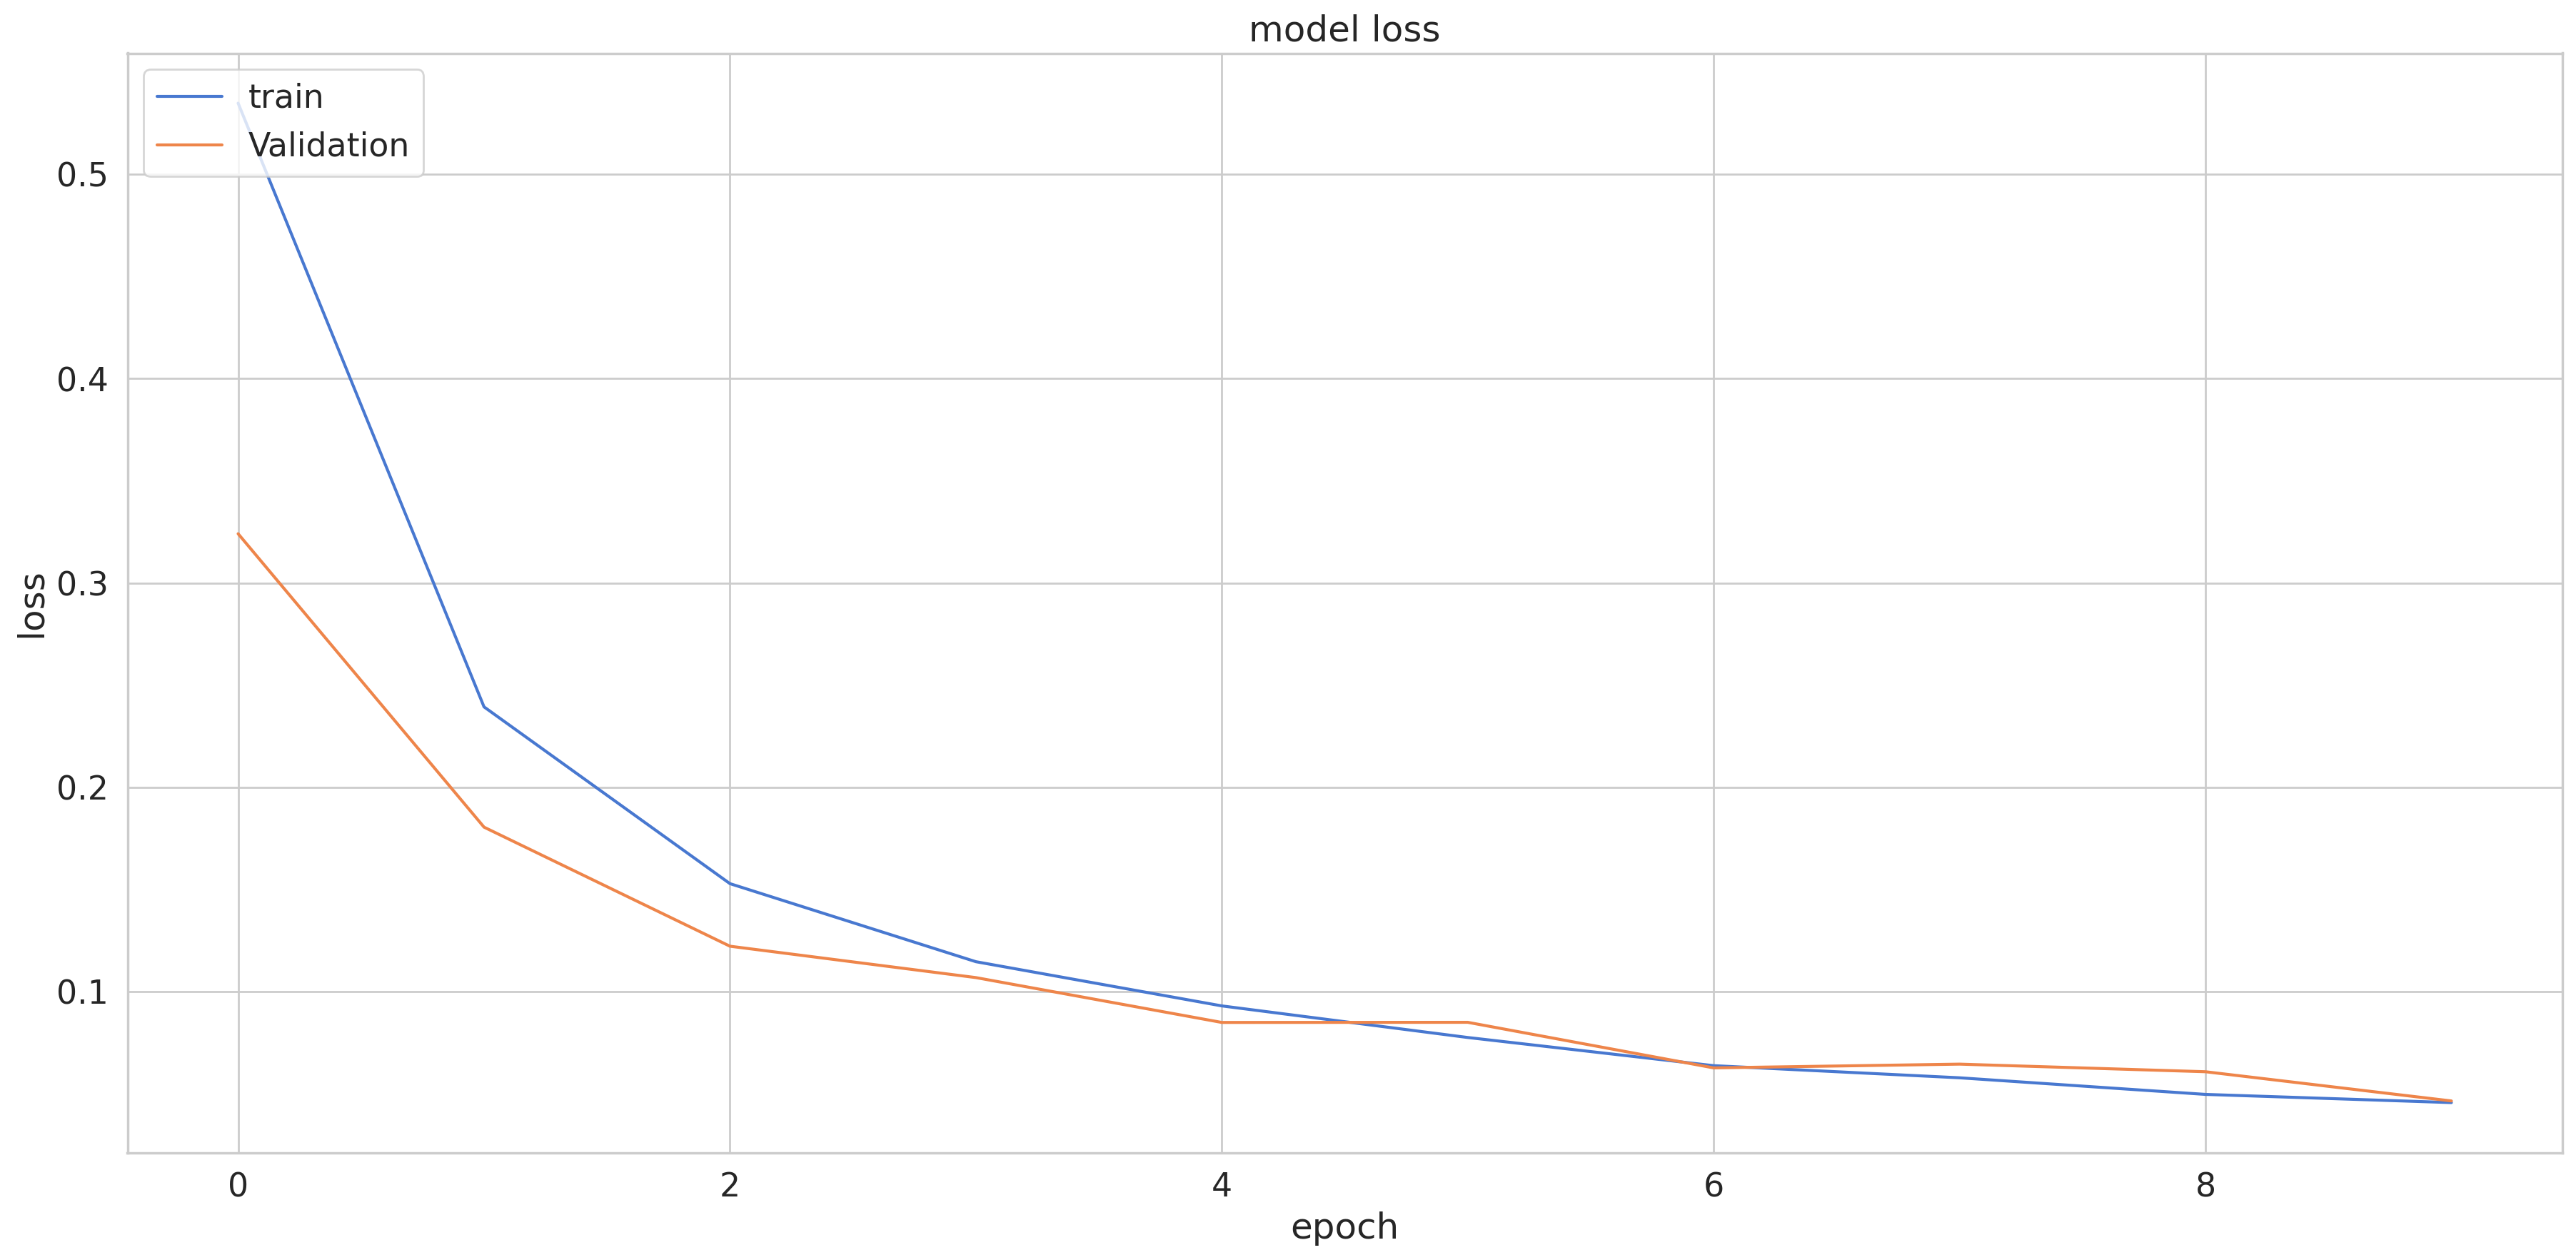

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

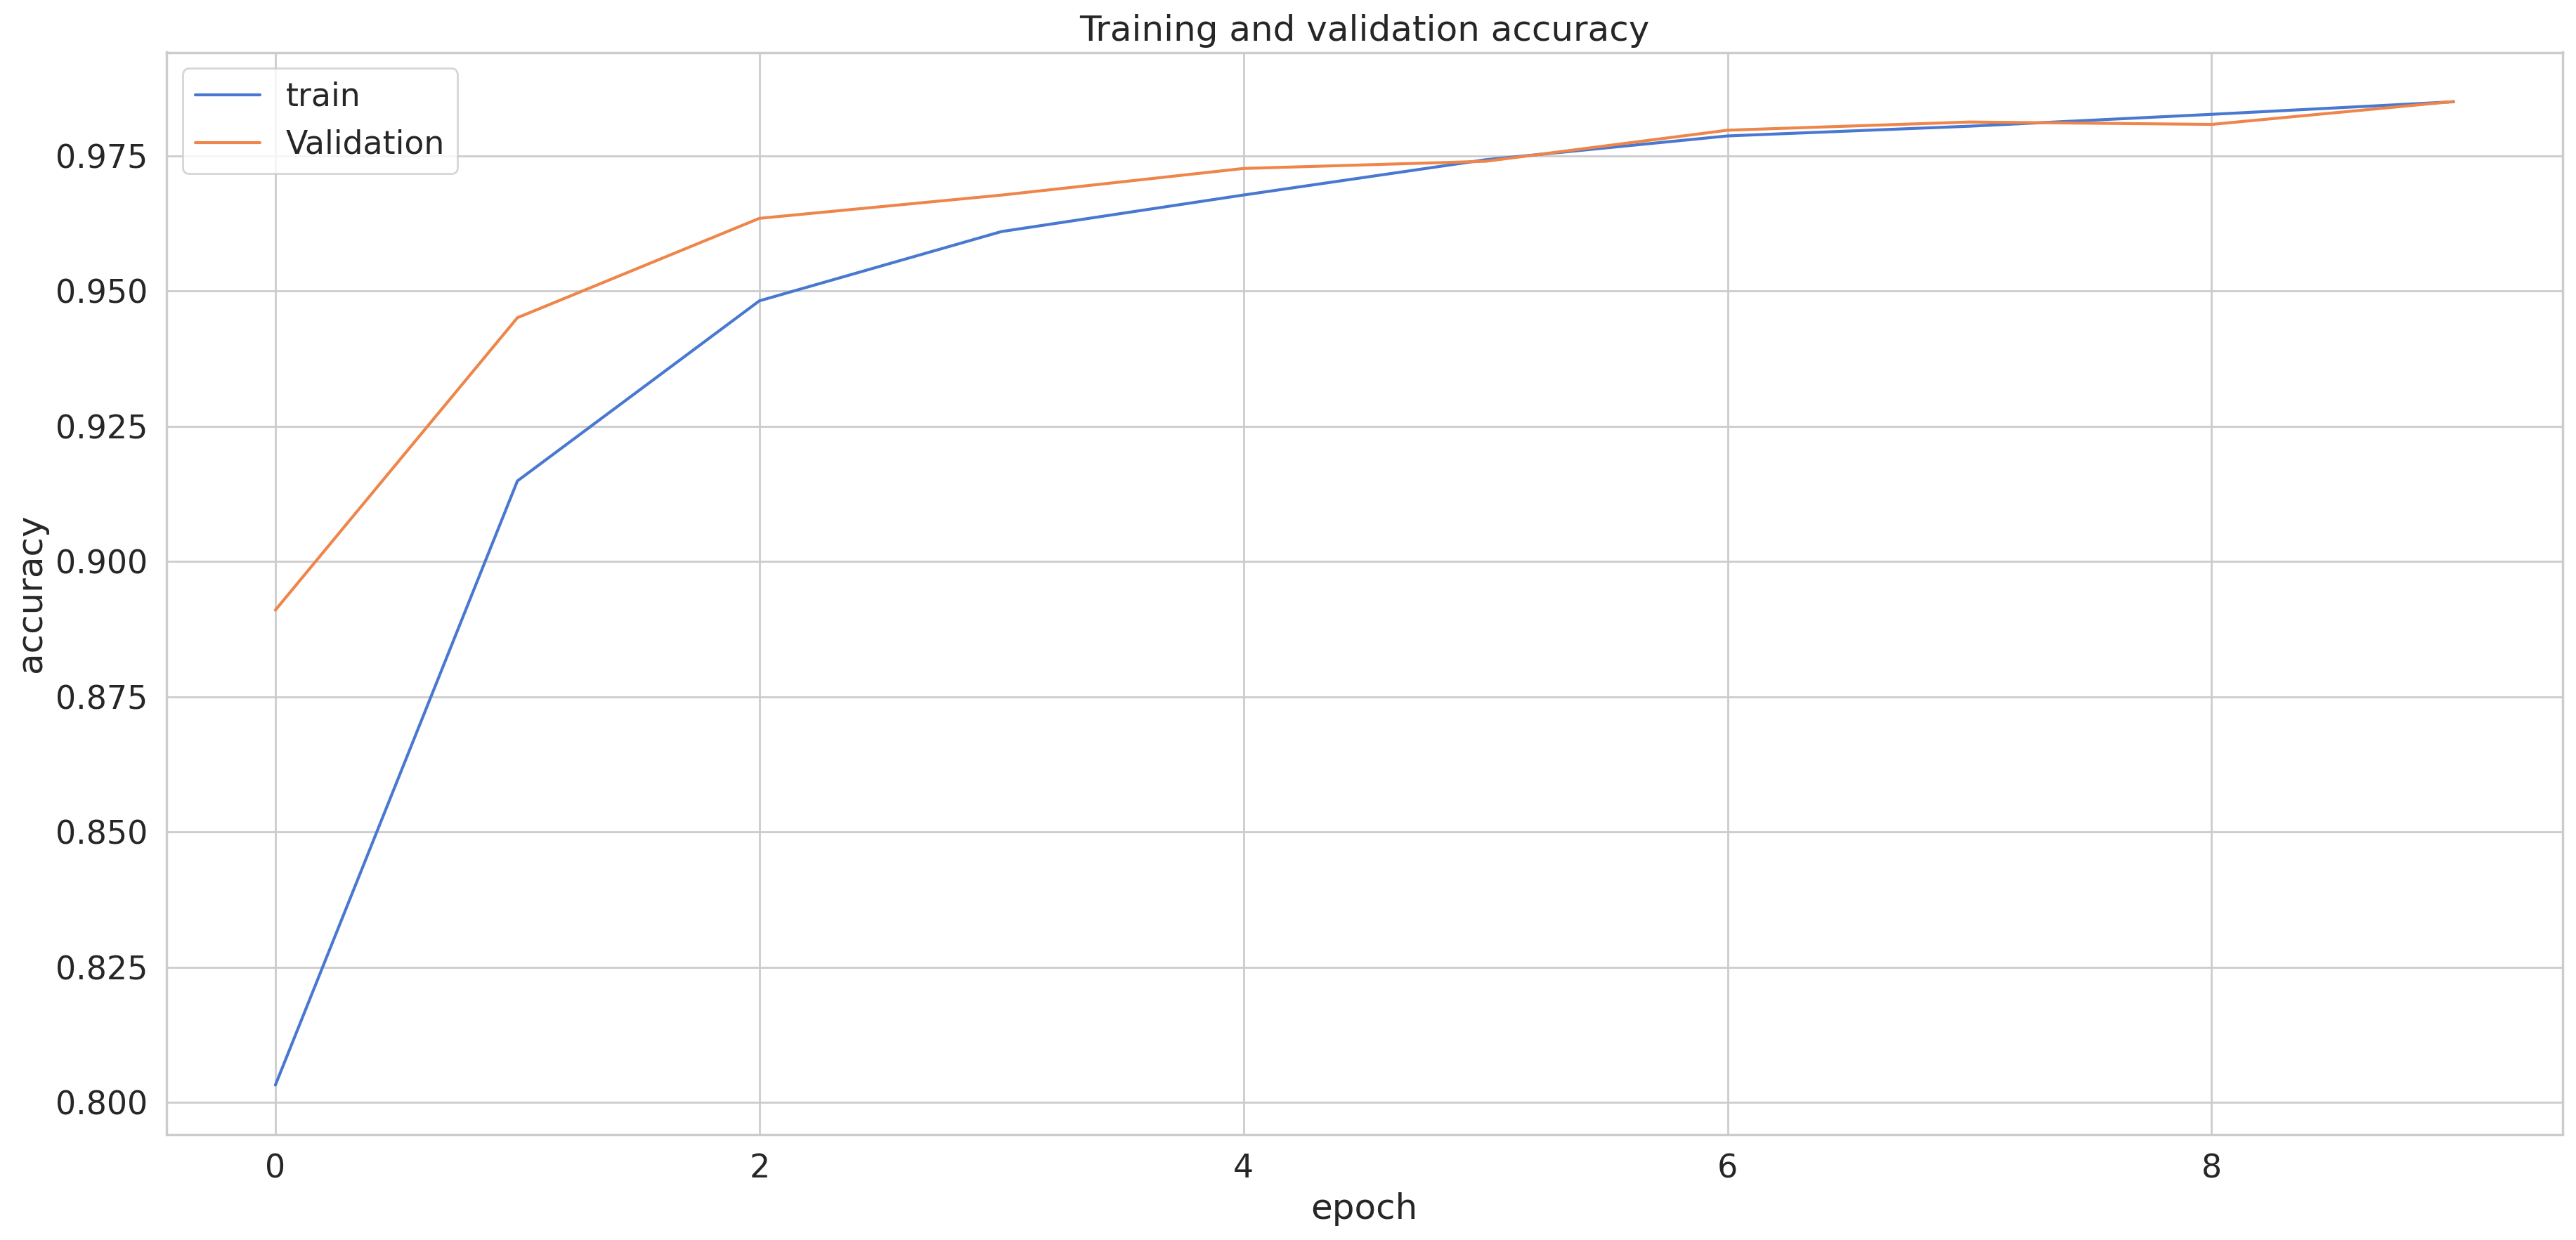

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 39s 62ms/step
f1_score =  0.9864919726800023
0.9865131080466737
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       0.99      0.99      0.99      6843
           2       0.96      0.97      0.96      2459
           3       0.97      0.95      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.98      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

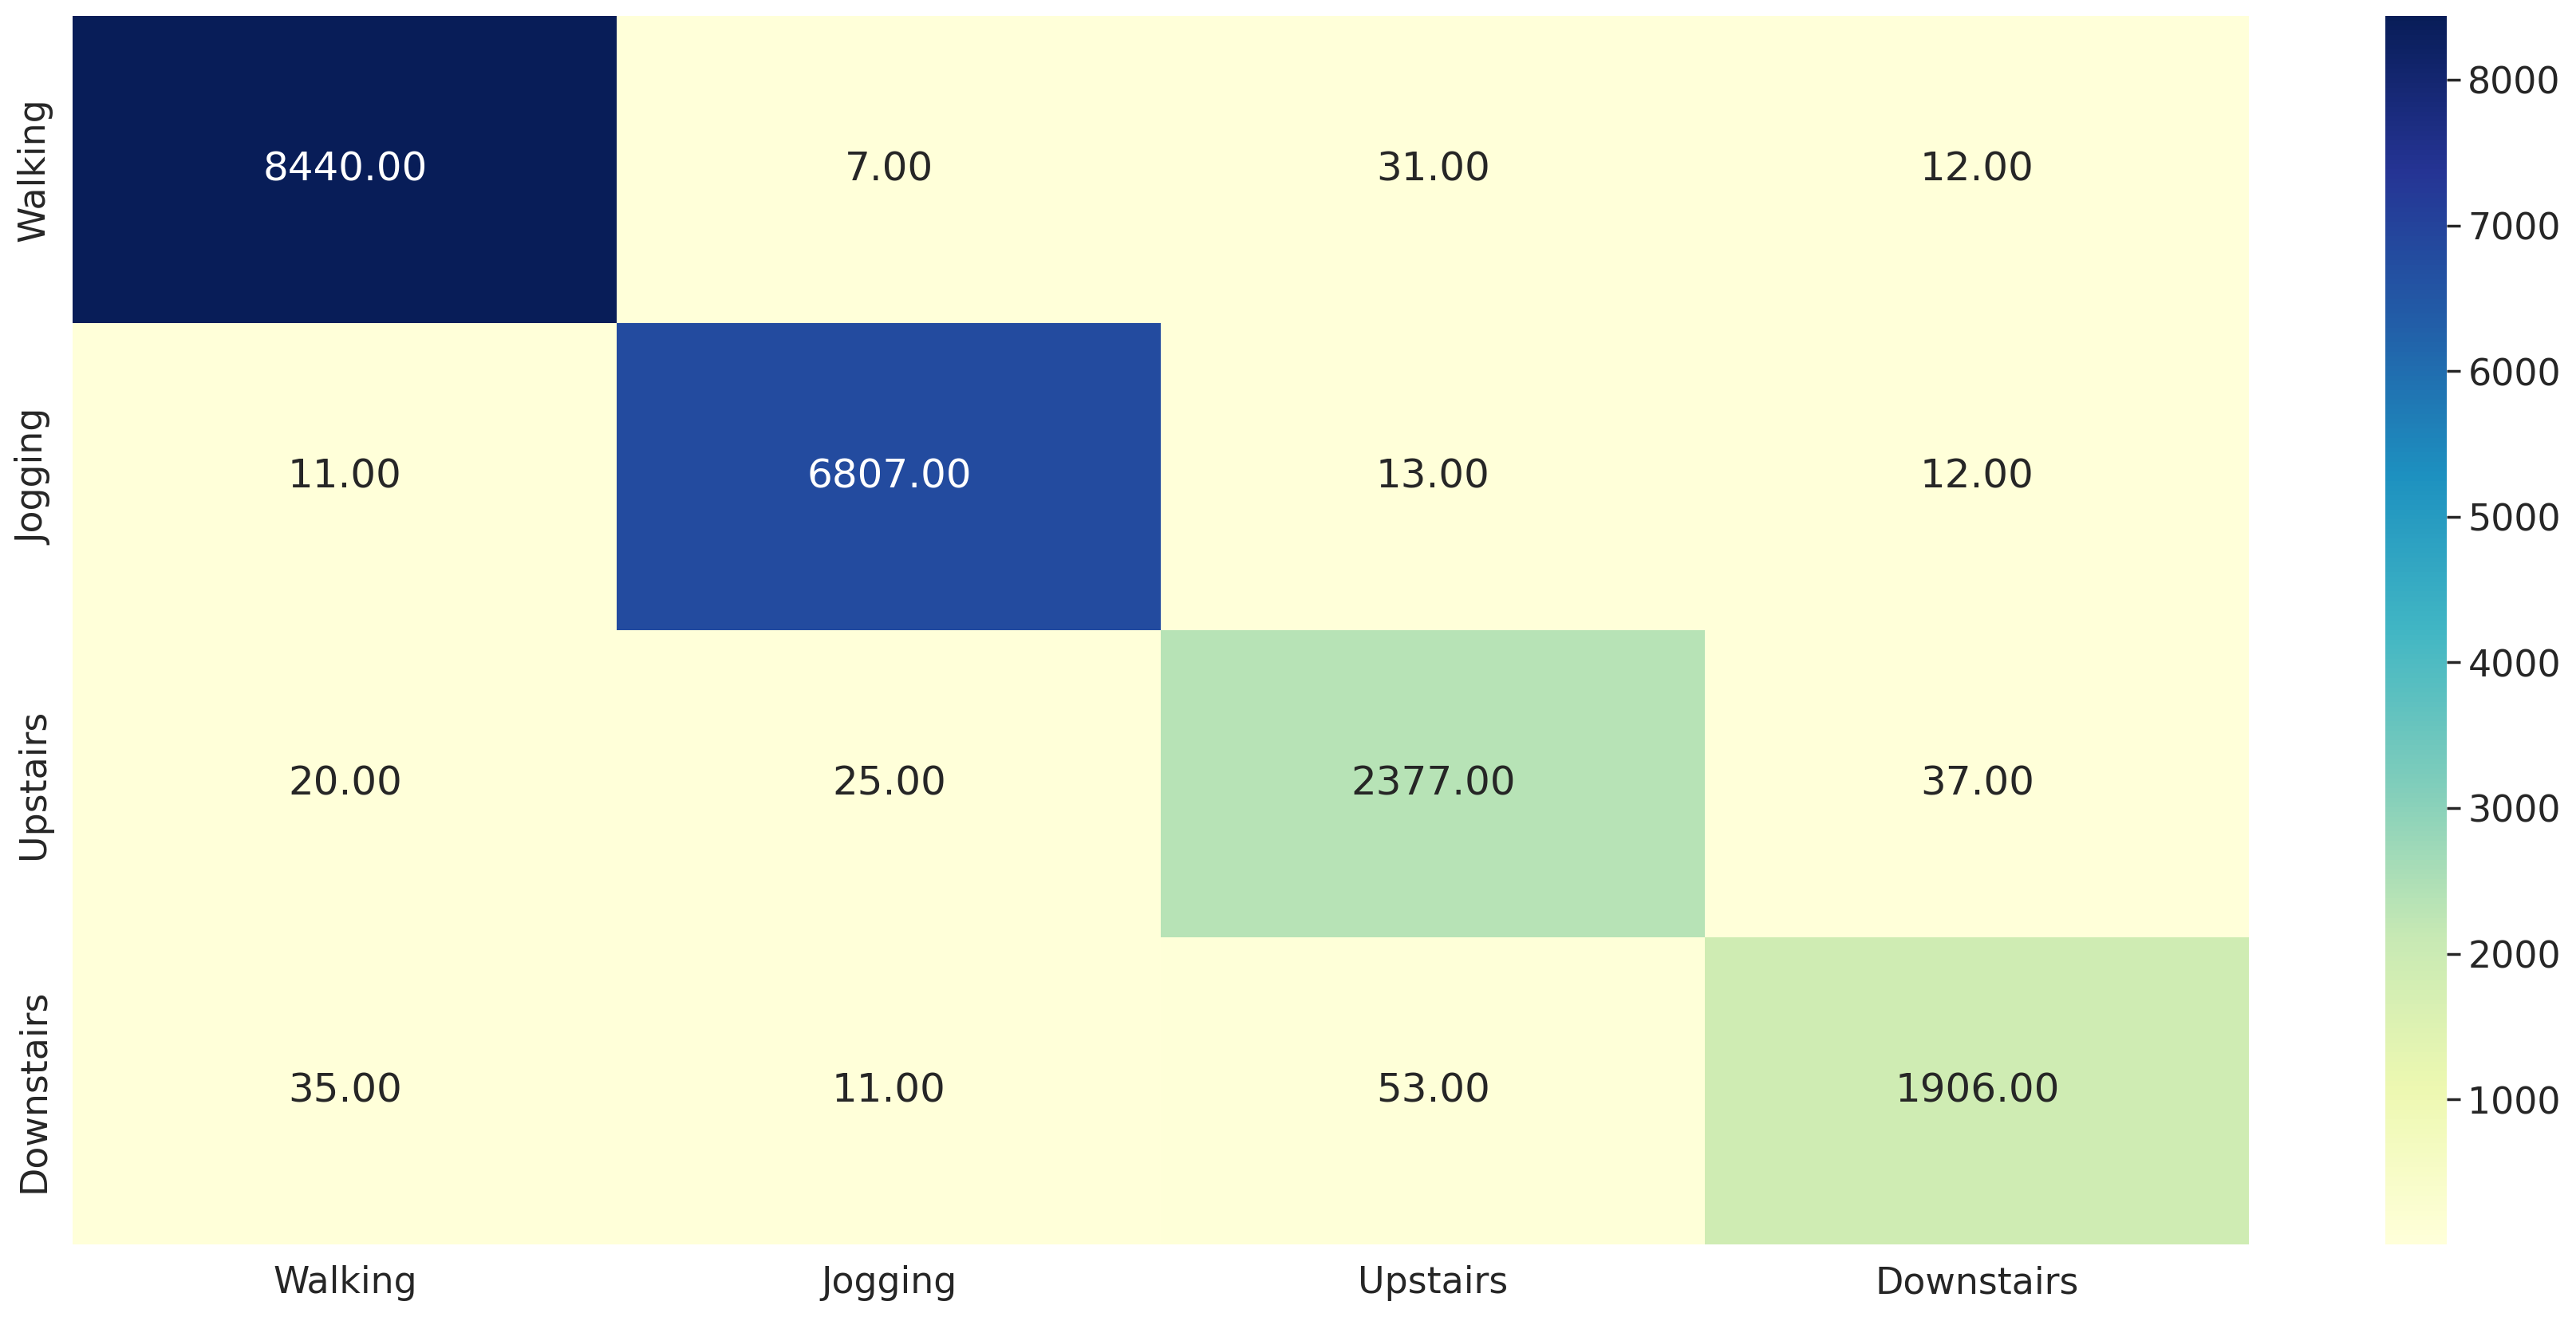

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2 - CNN2

In [30]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_7 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 48, 64)            24640     
                                                                 
 conv1d_5 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 dropout_9 (Dropout)         (None, 46, 64)           

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 217s 428ms/step - loss: 0.5127 - accuracy: 0.8099 - val_loss: 0.2955 - val_accuracy: 0.8997
Epoch 2/10
495/495 [==============================] - 211s 426ms/step - loss: 0.2175 - accuracy: 0.9234 - val_loss: 0.1672 - val_accuracy: 0.9455
Epoch 3/10
495/495 [==============================] - 205s 414ms/step - loss: 0.1474 - accuracy: 0.9493 - val_loss: 0.1302 - val_accuracy: 0.9587
Epoch 4/10
495/495 [==============================] - 215s 434ms/step - loss: 0.1143 - accuracy: 0.9603 - val_loss: 0.1057 - val_accuracy: 0.9648
Epoch 5/10
495/495 [==============================] - 211s 427ms/step - loss: 0.0938 - accuracy: 0.9679 - val_loss: 0.0792 - val_accuracy: 0.9744
Epoch 6/10
495/495 [==============================] - 210s 423ms/step - loss: 0.0789 - accuracy: 0.9726 - val_loss: 0.0757 - val_accuracy: 0.9725
Epoch 7/10
495/495 [==============================] - 212s 428ms/step - loss: 0.0678 - accuracy: 0.9765 - val_loss: 0.0906 -

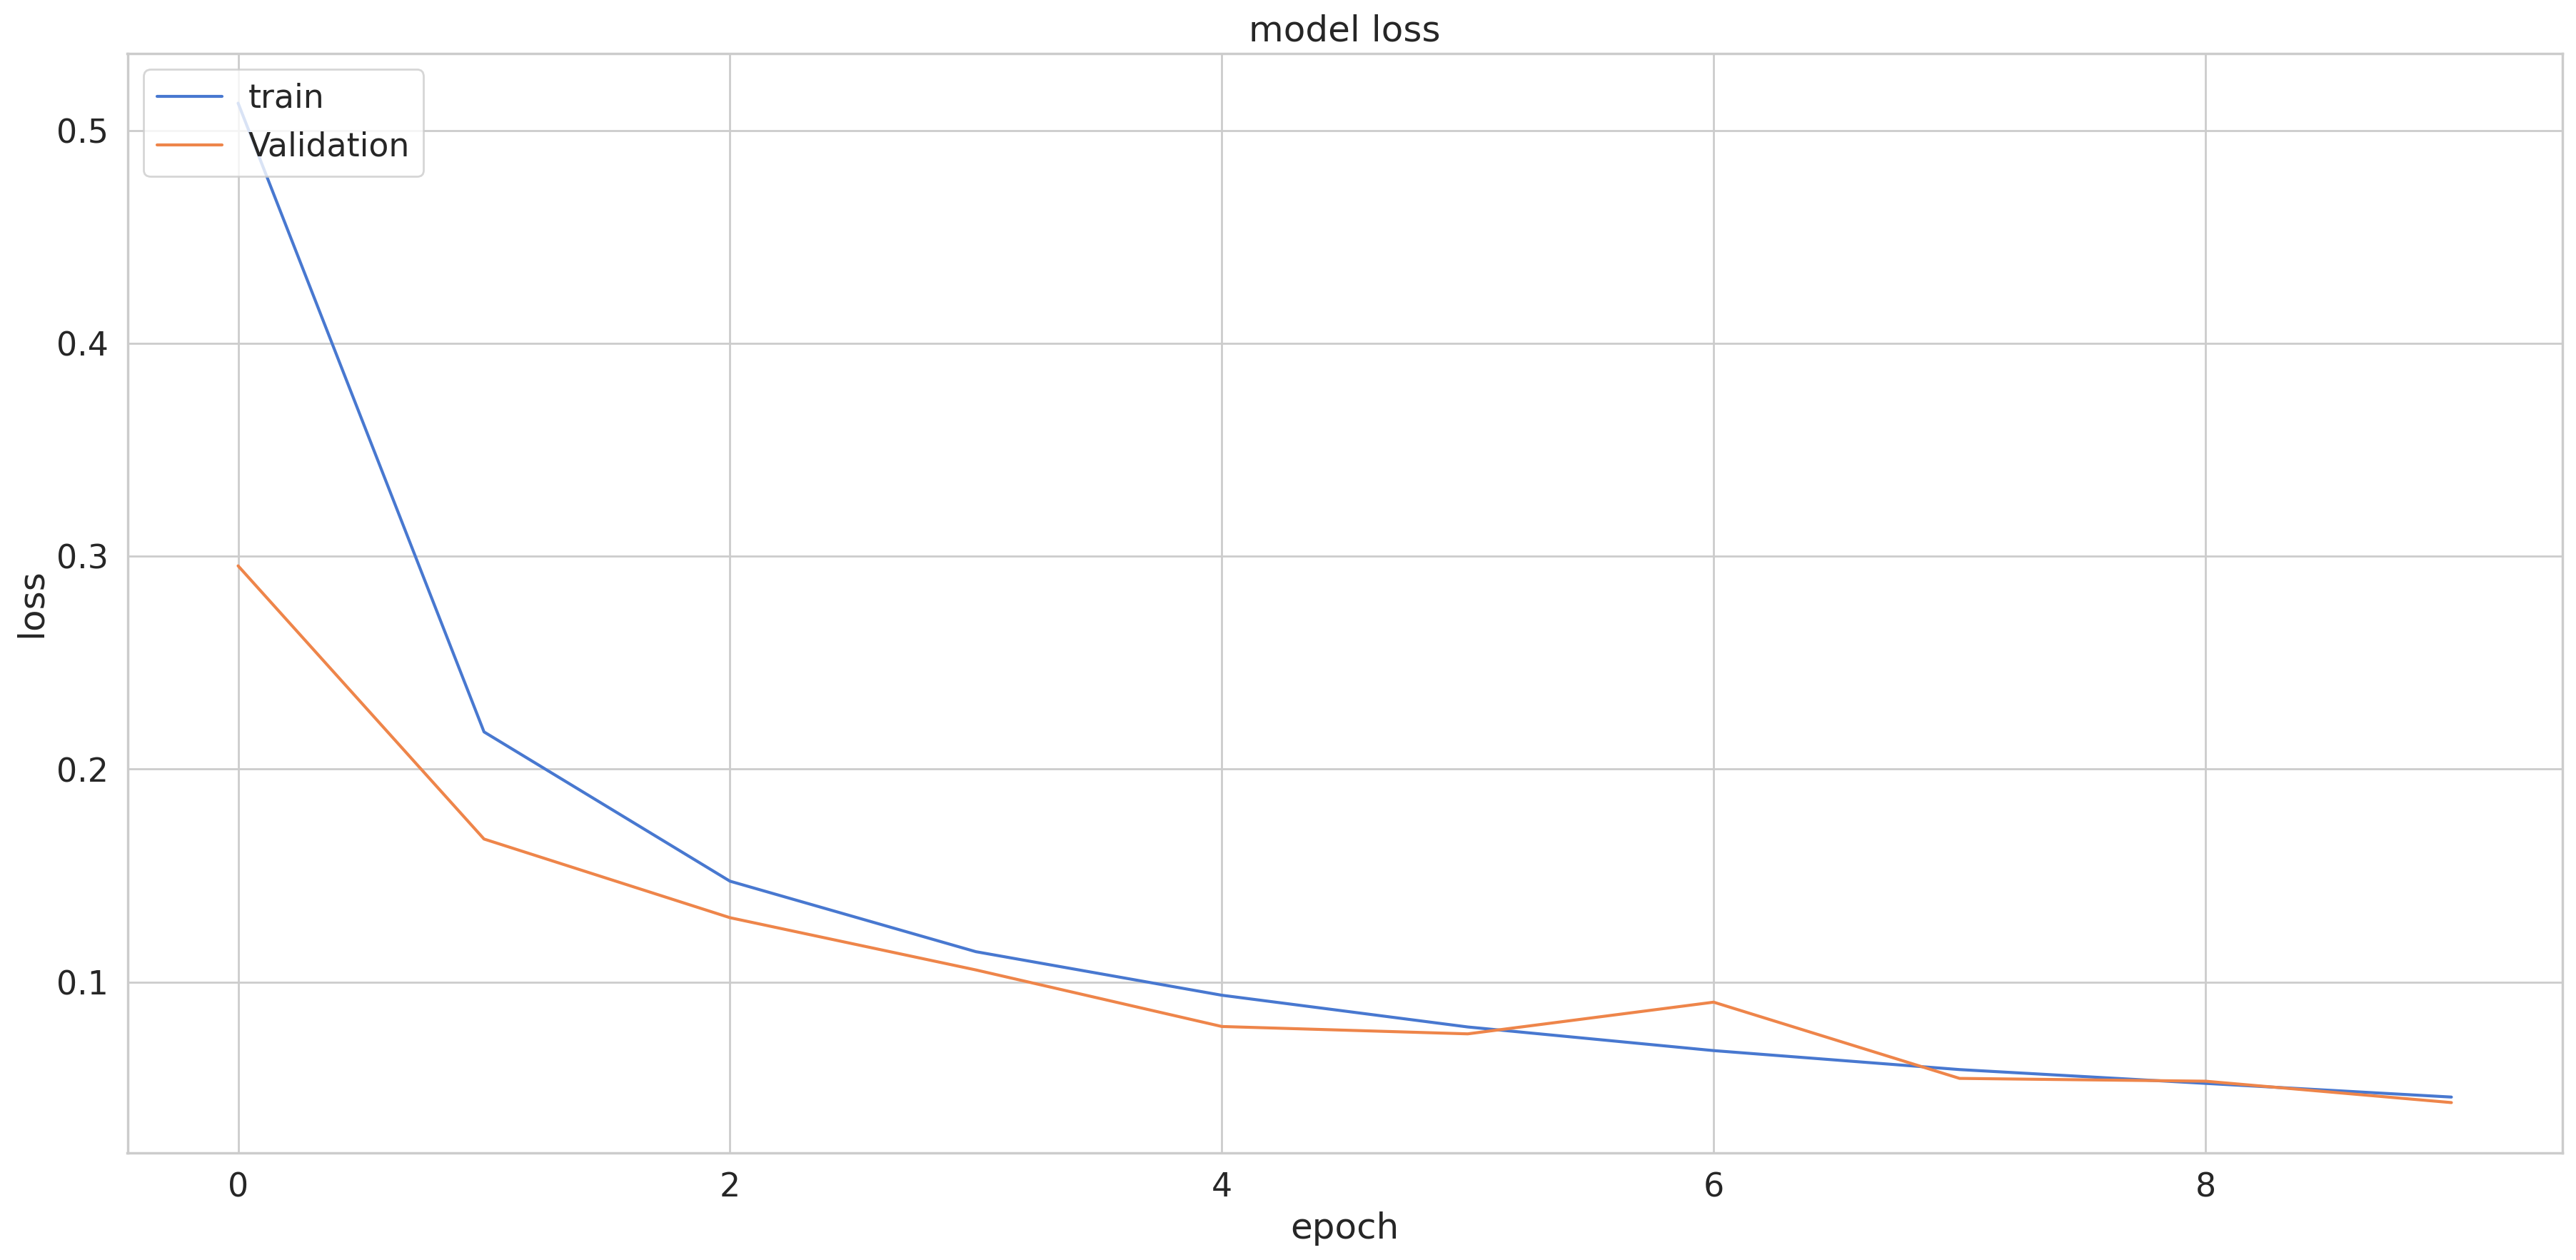

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

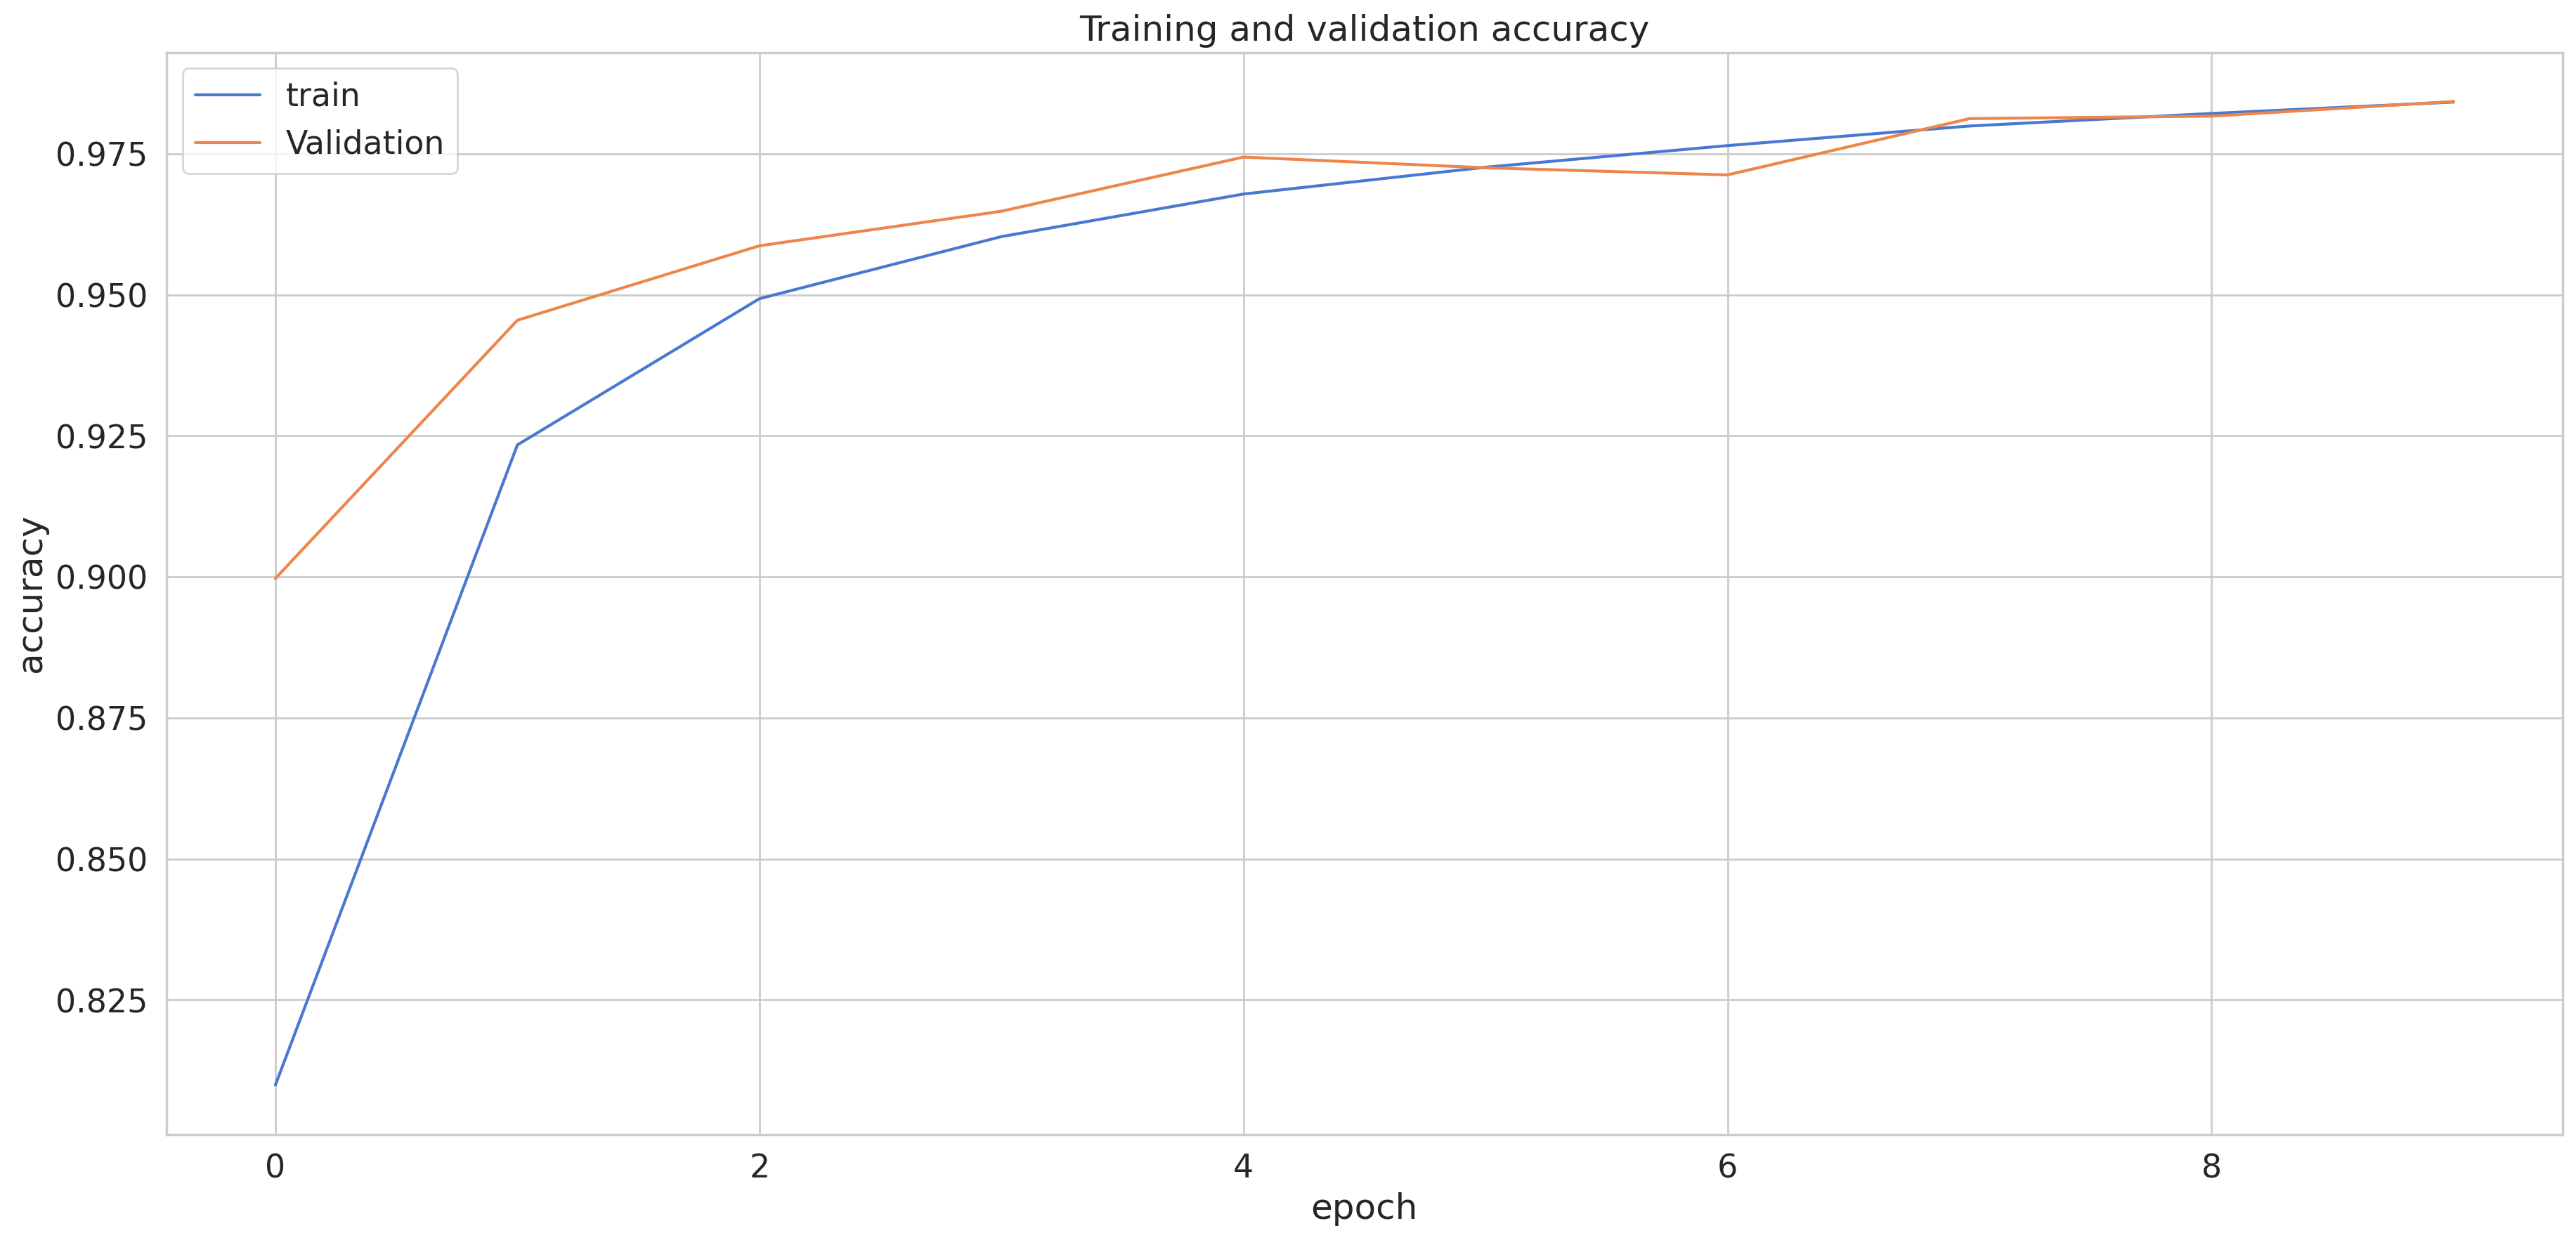

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 41s 65ms/step
f1_score =  0.9855081595576083
0.9855028539677729
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       0.99      0.99      0.99      6843
           2       0.97      0.95      0.96      2459
           3       0.95      0.98      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.98      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

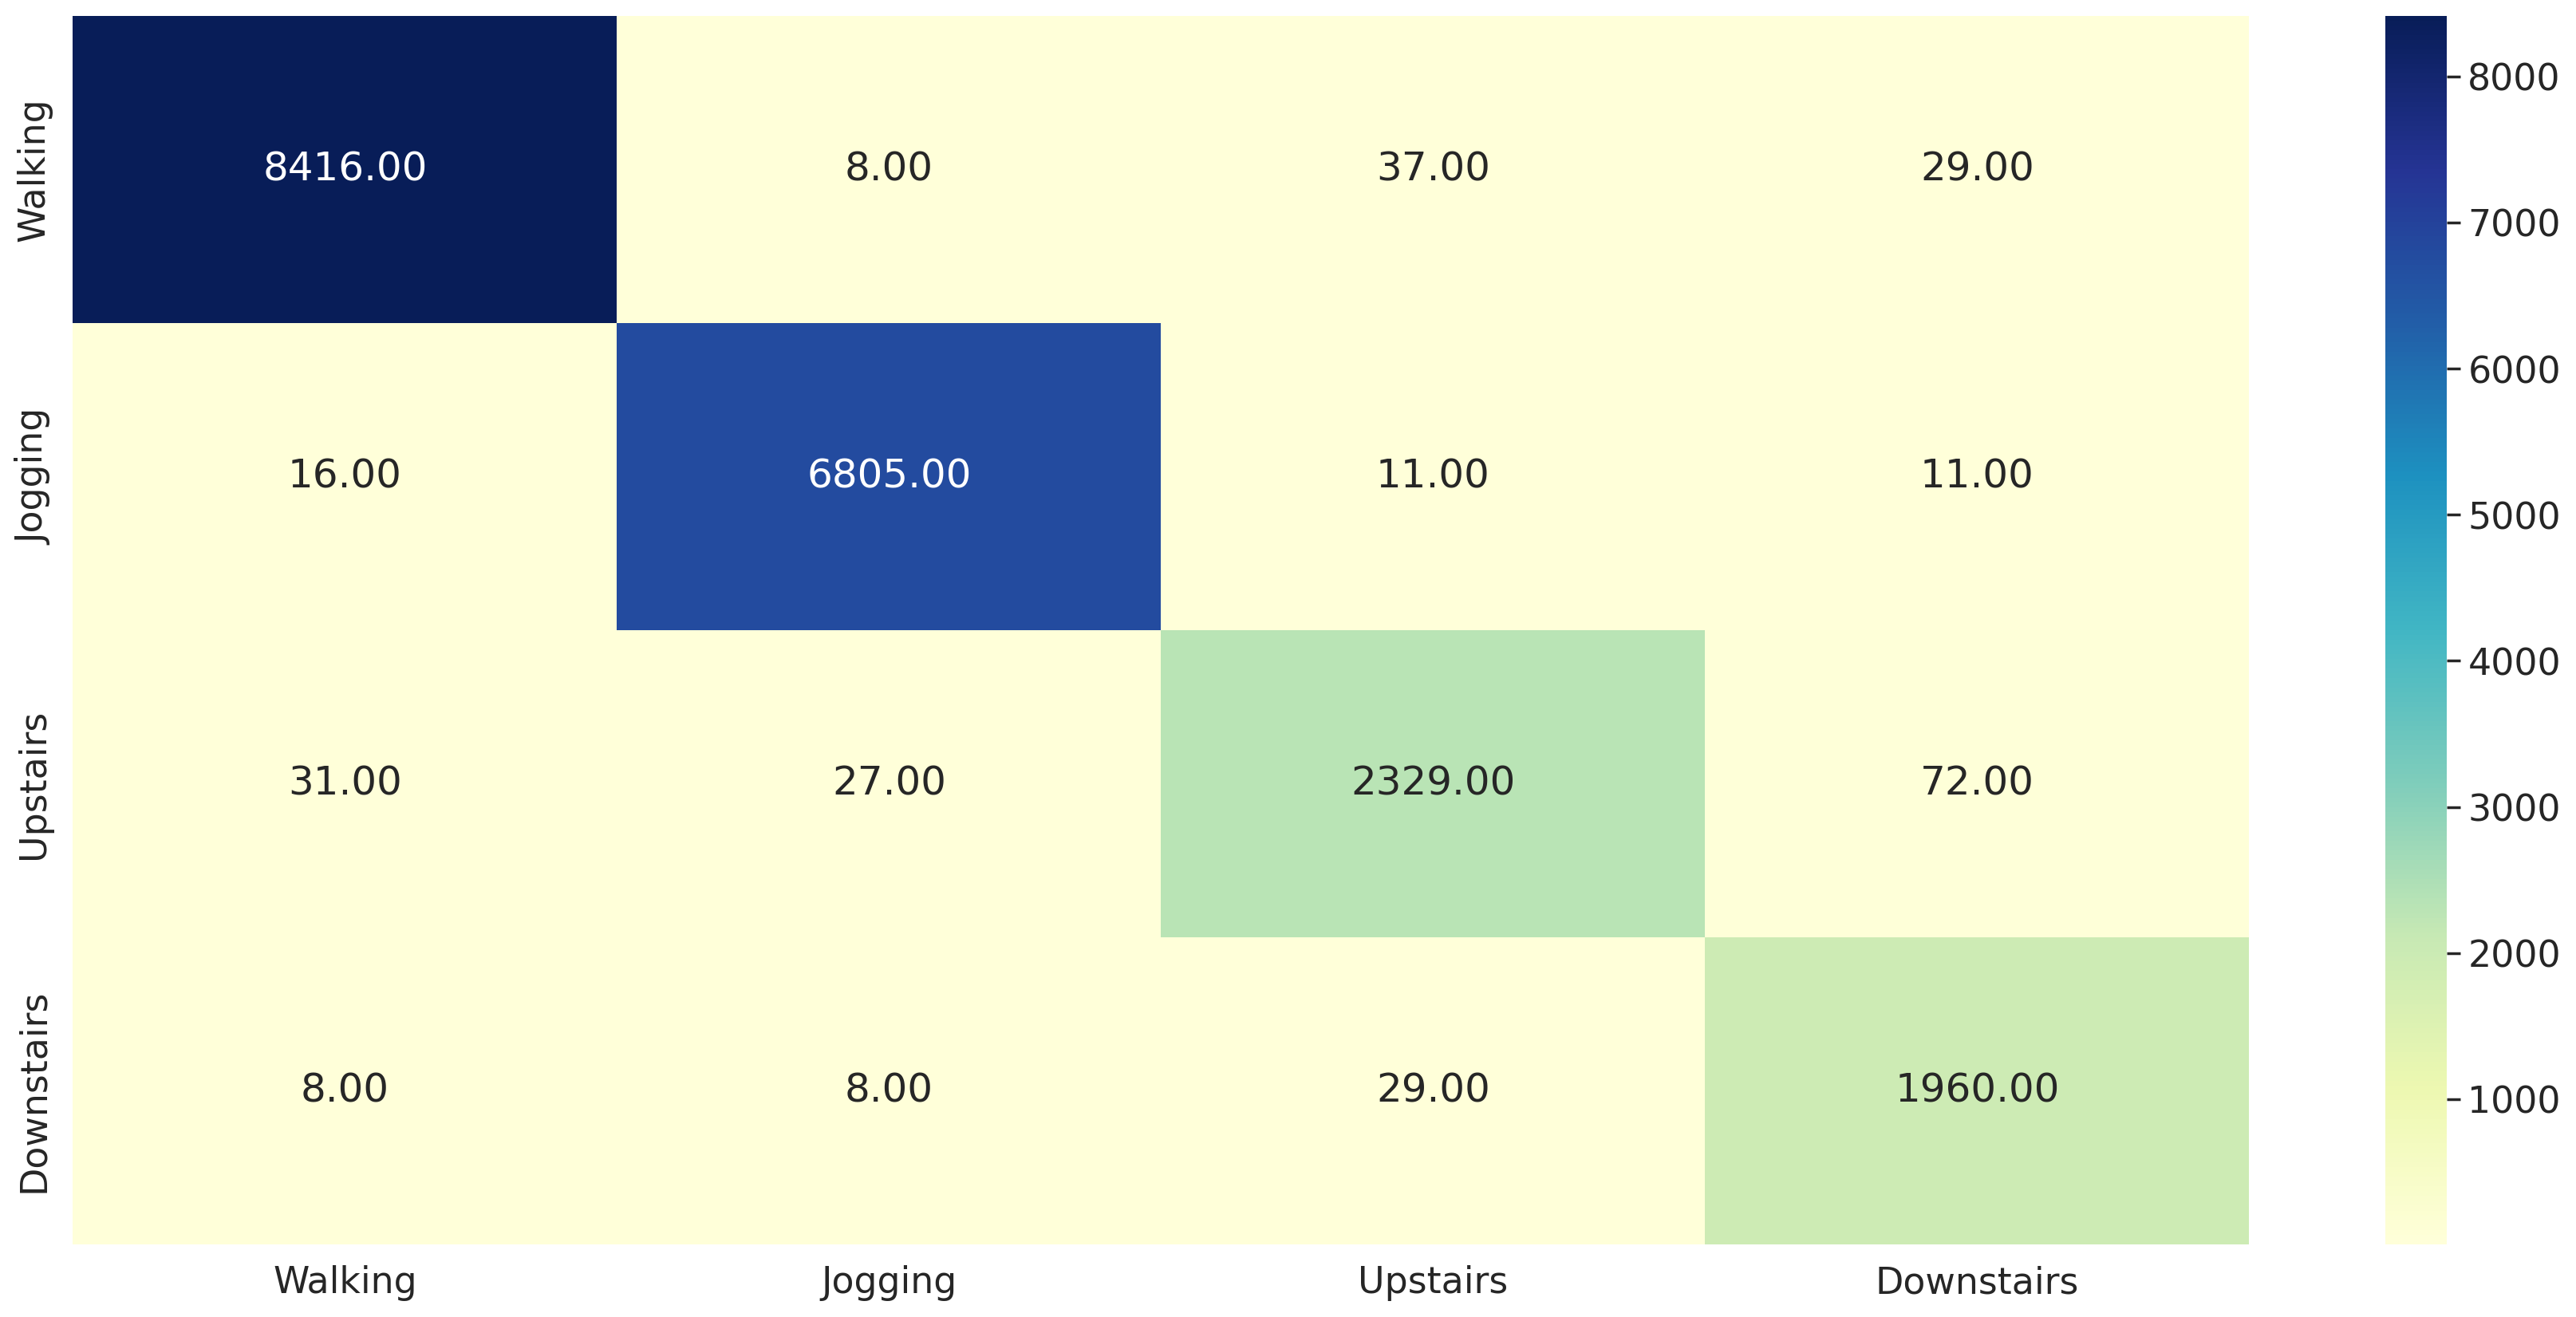

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')